## Preprocess RNA-seq data

### Step 0. Load necessary libraries

In [1]:


if (!requireNamespace("Seurat", quietly = TRUE)) {
  install.packages("Seurat")
    BiocManager::install("sctransform")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}

if (!requireNamespace("scDblFinder", quietly = TRUE)) {
    BiocManager::install("scDblFinder")
}

if (!requireNamespace("harmony", quietly = TRUE)) {
    install.packages("harmony")
}


suppressPackageStartupMessages({
    suppressWarnings({
        library(Seurat)
        library(scDblFinder)
        library(harmony)
        library(dplyr)
        
        library(ggplot2)
    })
})



### Step 1.  Merging Single-Cell RNA-seq Data from Different Samples with Seurat  

##### 1st sample

In [ ]:
start <- Sys.time()
data_sample1 <- Read10X_h5("../data/sample1/pbmc_unsorted_10k_filtered_feature_bc_matrix.h5")
rna_sample1 <- CreateSeuratObject(data_sample1)
end <- Sys.time()
print(end - start)

Genome matrix has multiple modalities, returning a list of matrices for this genome



Time difference of 23.87959 secs


In [3]:
rna_sample1

An object of class Seurat 
148458 features across 12012 samples within 1 assay 
Active assay: RNA (148458 features, 0 variable features)
 2 layers present: counts.Gene Expression, counts.Peaks

In [4]:
dim(rna_sample1[["RNA"]]$counts)

Warning message in LayerData.Assay5(object = x, layer = i):
“multiple layers are identified by counts.Gene Expression counts.Peaks
 only the first layer is used”


[1] 36601 12012

##### 2nd sample

In [ ]:
start <- Sys.time()
data_sample2 <- Read10X_h5("../data/sample2/10k_PBMC_Multiome_nextgem_Chromium_Controller_filtered_feature_bc_matrix.h5")
rna_sample2 <- CreateSeuratObject(data_sample2)
end <- Sys.time()
print(end - start)

Genome matrix has multiple modalities, returning a list of matrices for this genome



Time difference of 21.18077 secs


In [6]:
rna_sample2

An object of class Seurat 
151780 features across 10691 samples within 1 assay 
Active assay: RNA (151780 features, 0 variable features)
 2 layers present: counts.Gene Expression, counts.Peaks

In [7]:
dim(rna_sample2[["RNA"]]$counts)

Warning message in LayerData.Assay5(object = x, layer = i):
“multiple layers are identified by counts.Gene Expression counts.Peaks
 only the first layer is used”


[1] 36601 10691

In [8]:
# add information to identify dataset of origin
rna_sample1$dataset <- 'sample1'
rna_sample2$dataset <- 'sample2'

# merge all datasets, adding a sample-based cell ID to make sure cell names are unique
rna_data <- merge(
  x = rna_sample1,
  y = rna_sample2,
  add.cell.ids = c("sample1","sample2")
)

rna_data <- JoinLayers(rna_data)


In [9]:
rna_data

An object of class Seurat 
263561 features across 22703 samples within 1 assay 
Active assay: RNA (263561 features, 0 variable features)
 1 layer present: counts

In [10]:
dim(rna_data[["RNA"]]$counts)

[1] 263561  22703

In [11]:
nrow(rna_data@meta.data)

[1] 22703

In [ ]:
saveRDS(rna_data,'../data/PBMC_rna.before_qc.rds')

### Step 2. Quality Control

#### a. Library Size

- `nCount_RNA` is the number of UMIs per cell. This is a measure of the total number of transcripts detected in a cell and is the way to visualize library size. 

- Cells with low `nCount_RNA` values may be dying cells or biologically relevant cell types with low mRNA content such as neutrophils.

- Cells with high nCount_RNA values may be doublets or very large cells like macrophages.



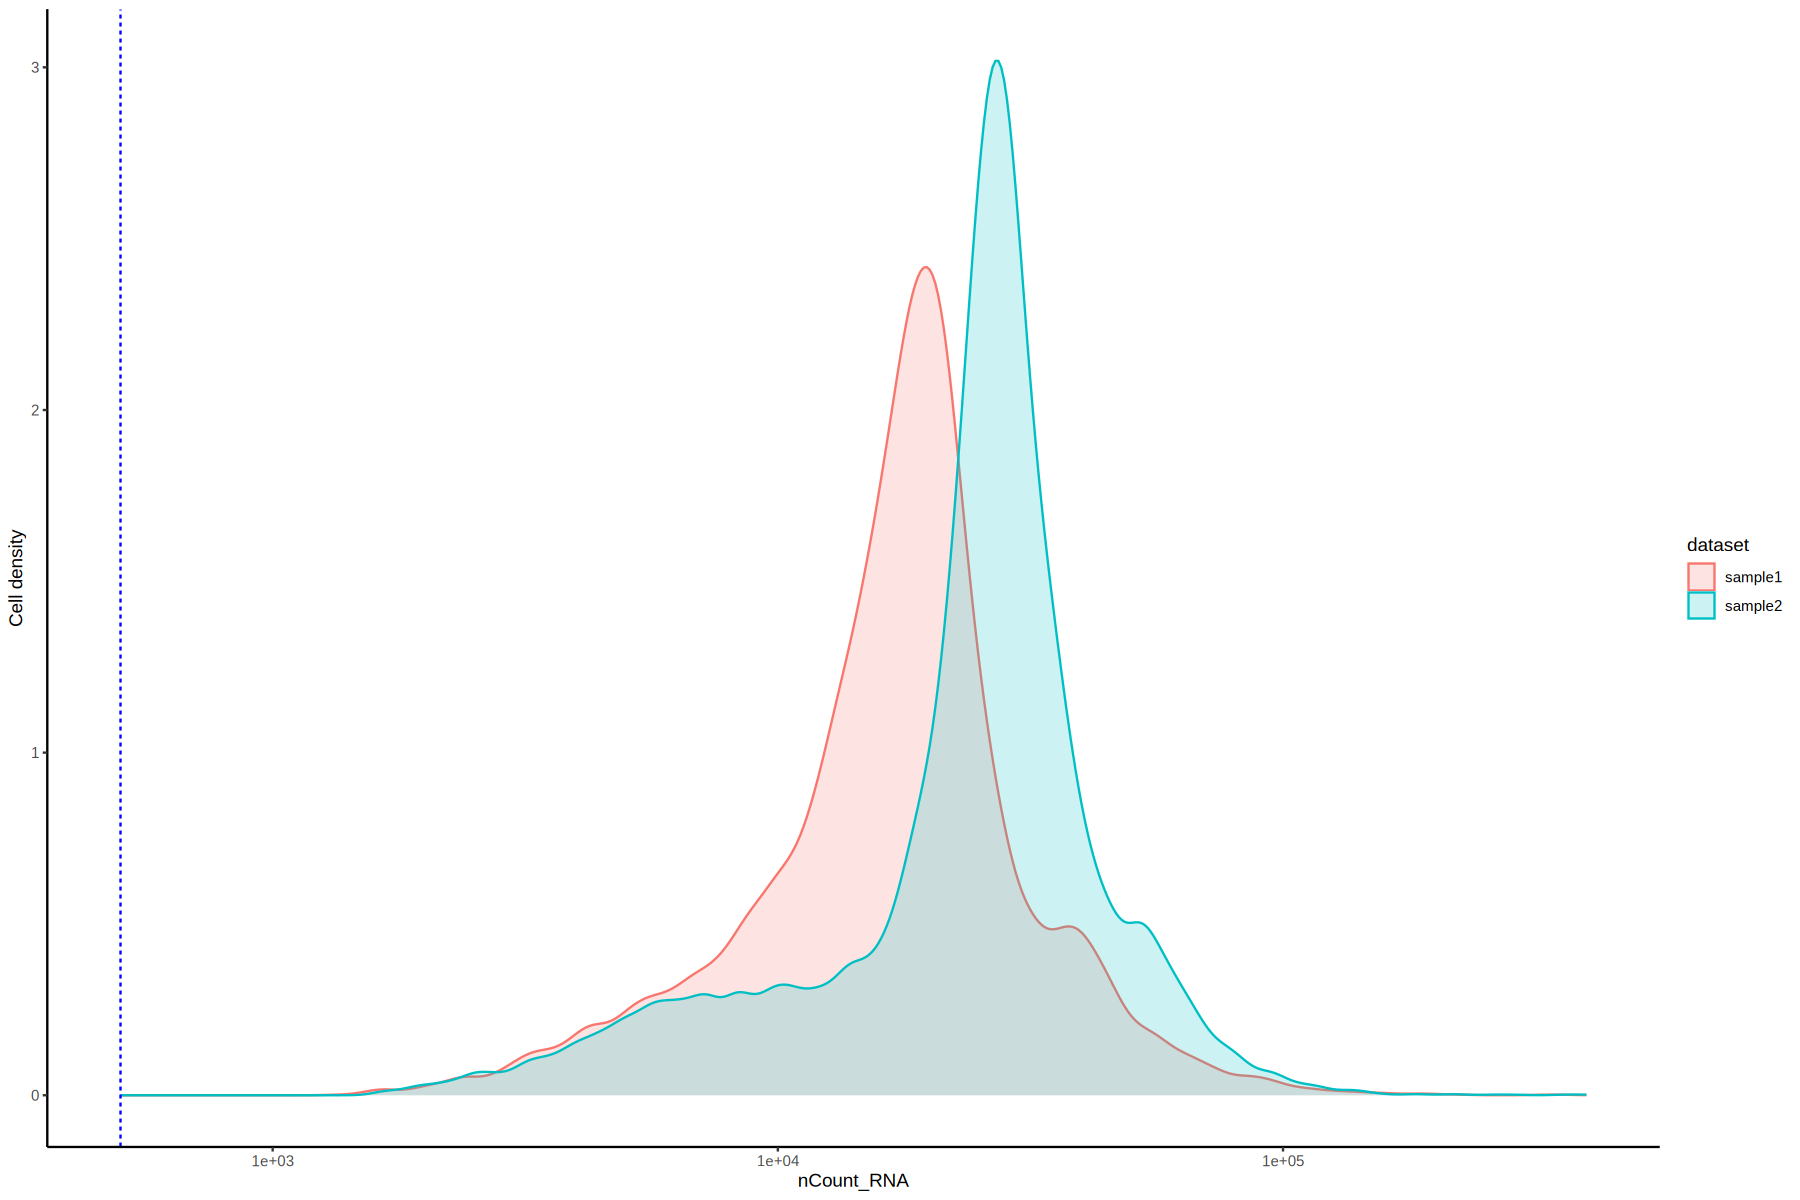

In [26]:
# plot number of UMIs per cell

options(repr.plot.width = 15, repr.plot.height = 10)

rna_data@meta.data |>
  	ggplot(aes(color=dataset, x=nCount_RNA, fill=dataset)) + 
  	geom_density(alpha = 0.2) + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") + 
    # geom_vline(xintercept = 1500, color = "blue", linetype = "dashed")
    geom_vline(xintercept = 500, color = "blue", linetype = "dashed")



#### b. Library Complexity

`nFeature_RNA` is the number of genes detected in a cell. Similarly, we want to look for cells with significantly low or high feature count. The feature count distribution gives us an idea of library complexity while UMI counts looks at library size.

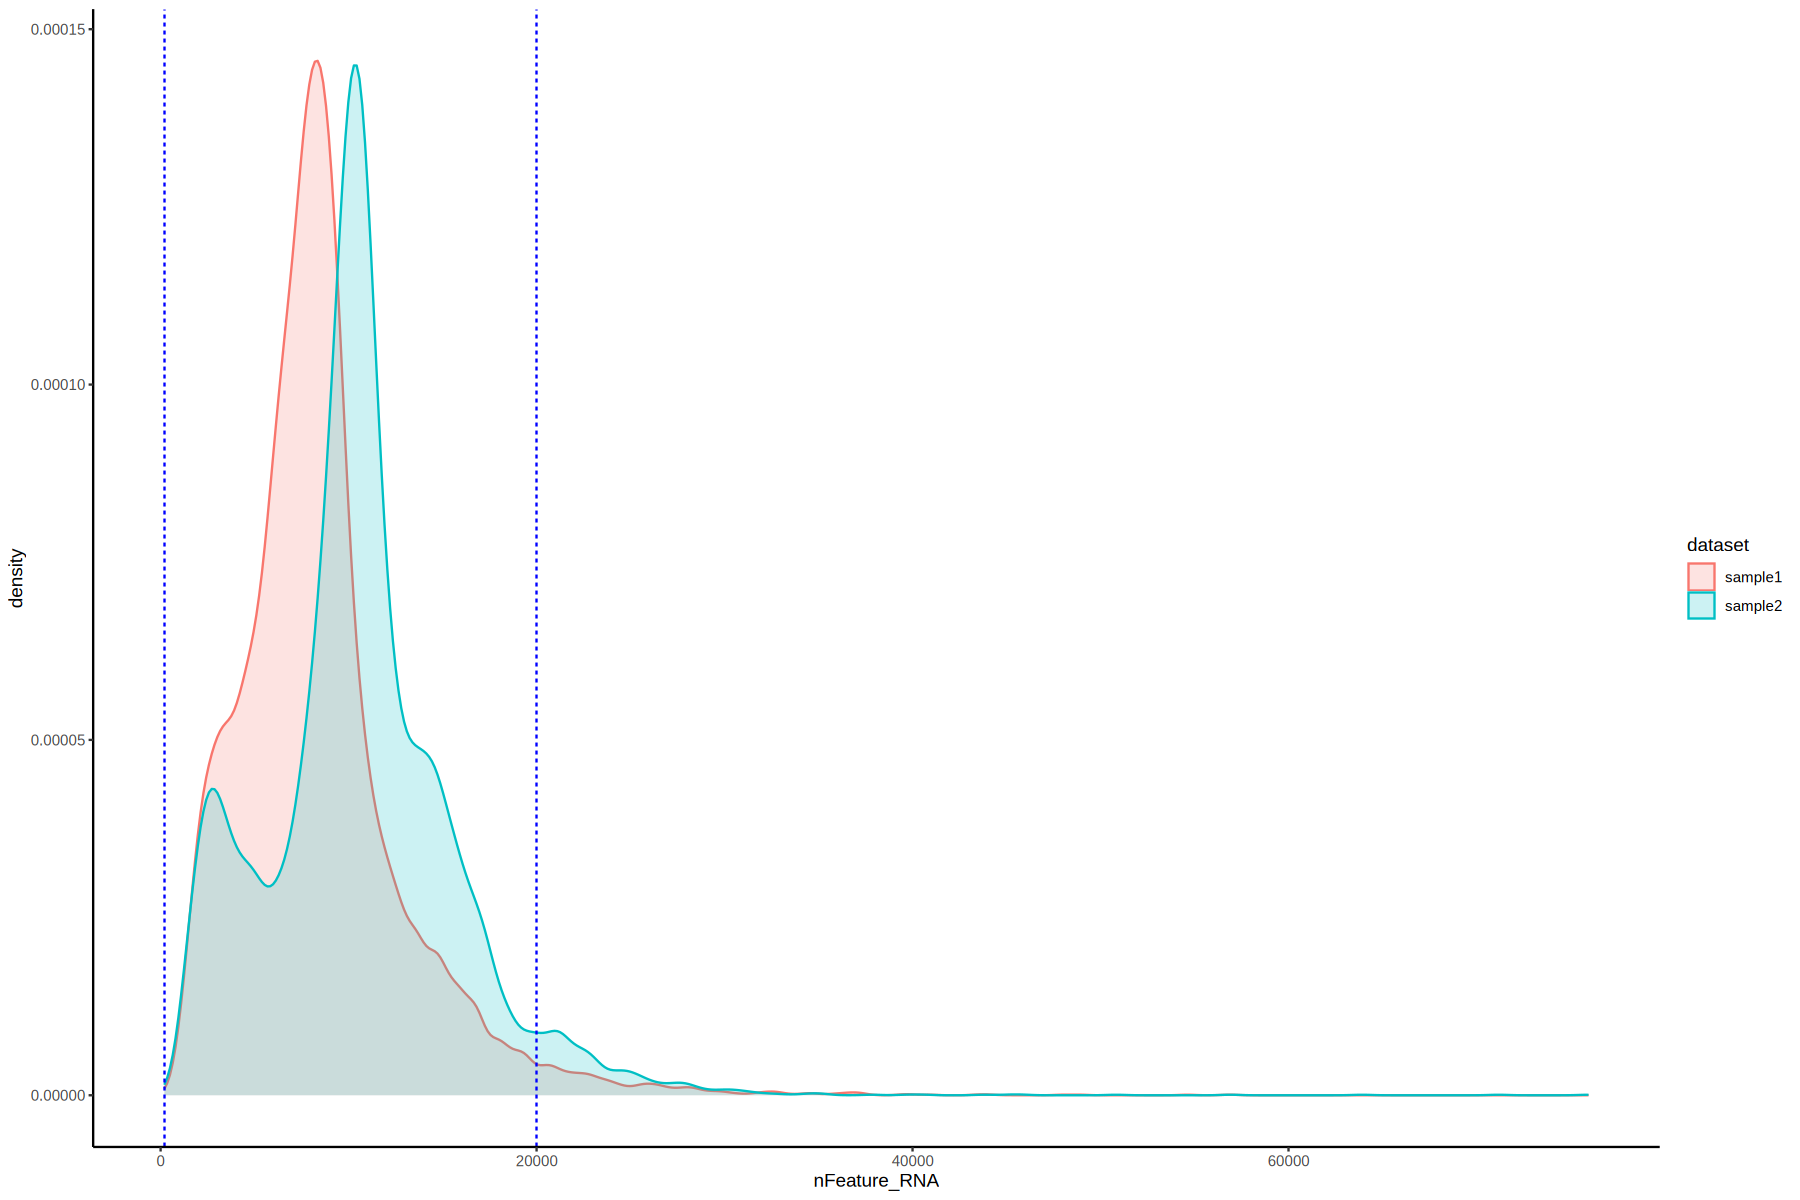

In [27]:
# plot number of features/genes per cell
options(repr.plot.width = 15, repr.plot.height = 10)

rna_data@meta.data |>
  	ggplot(aes(color=dataset, x=nFeature_RNA, fill=dataset)) + 
  	geom_density(alpha = 0.2) + 
  	theme_classic() +
  	# scale_x_log10() + 
  	geom_vline(xintercept = 200, col = "blue", linetype = "dashed") +
    geom_vline(xintercept = 20000, col = "blue", linetype = "dashed")



#### c. Percentage of mitochondrial genes

Seurat’s `PercentageFeatureSet` function calculates the percentage of a feature set in each cell. This function is useful for calculating the percentage of mitochondrial genes, ribosomal genes, or any other gene set of interest using regular expression (string matching) to filter these out by gene name.


In [22]:
# Calculate the percentage of mitochondrial genes
rna_data <- PercentageFeatureSet(rna_data, pattern = "^MT-", col.name = "perc.mt")

# Calculate the percentage of ribosomal genes
rna_data <- PercentageFeatureSet(rna_data, pattern = "^RPS|^RPL", col.name = "perc.ribo")

# Calculate the percentage of hemoglobin genes
rna_data <- PercentageFeatureSet(rna_data, pattern = "^HB[^(P)]", col.name = "perc.hb")

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_density()`).”


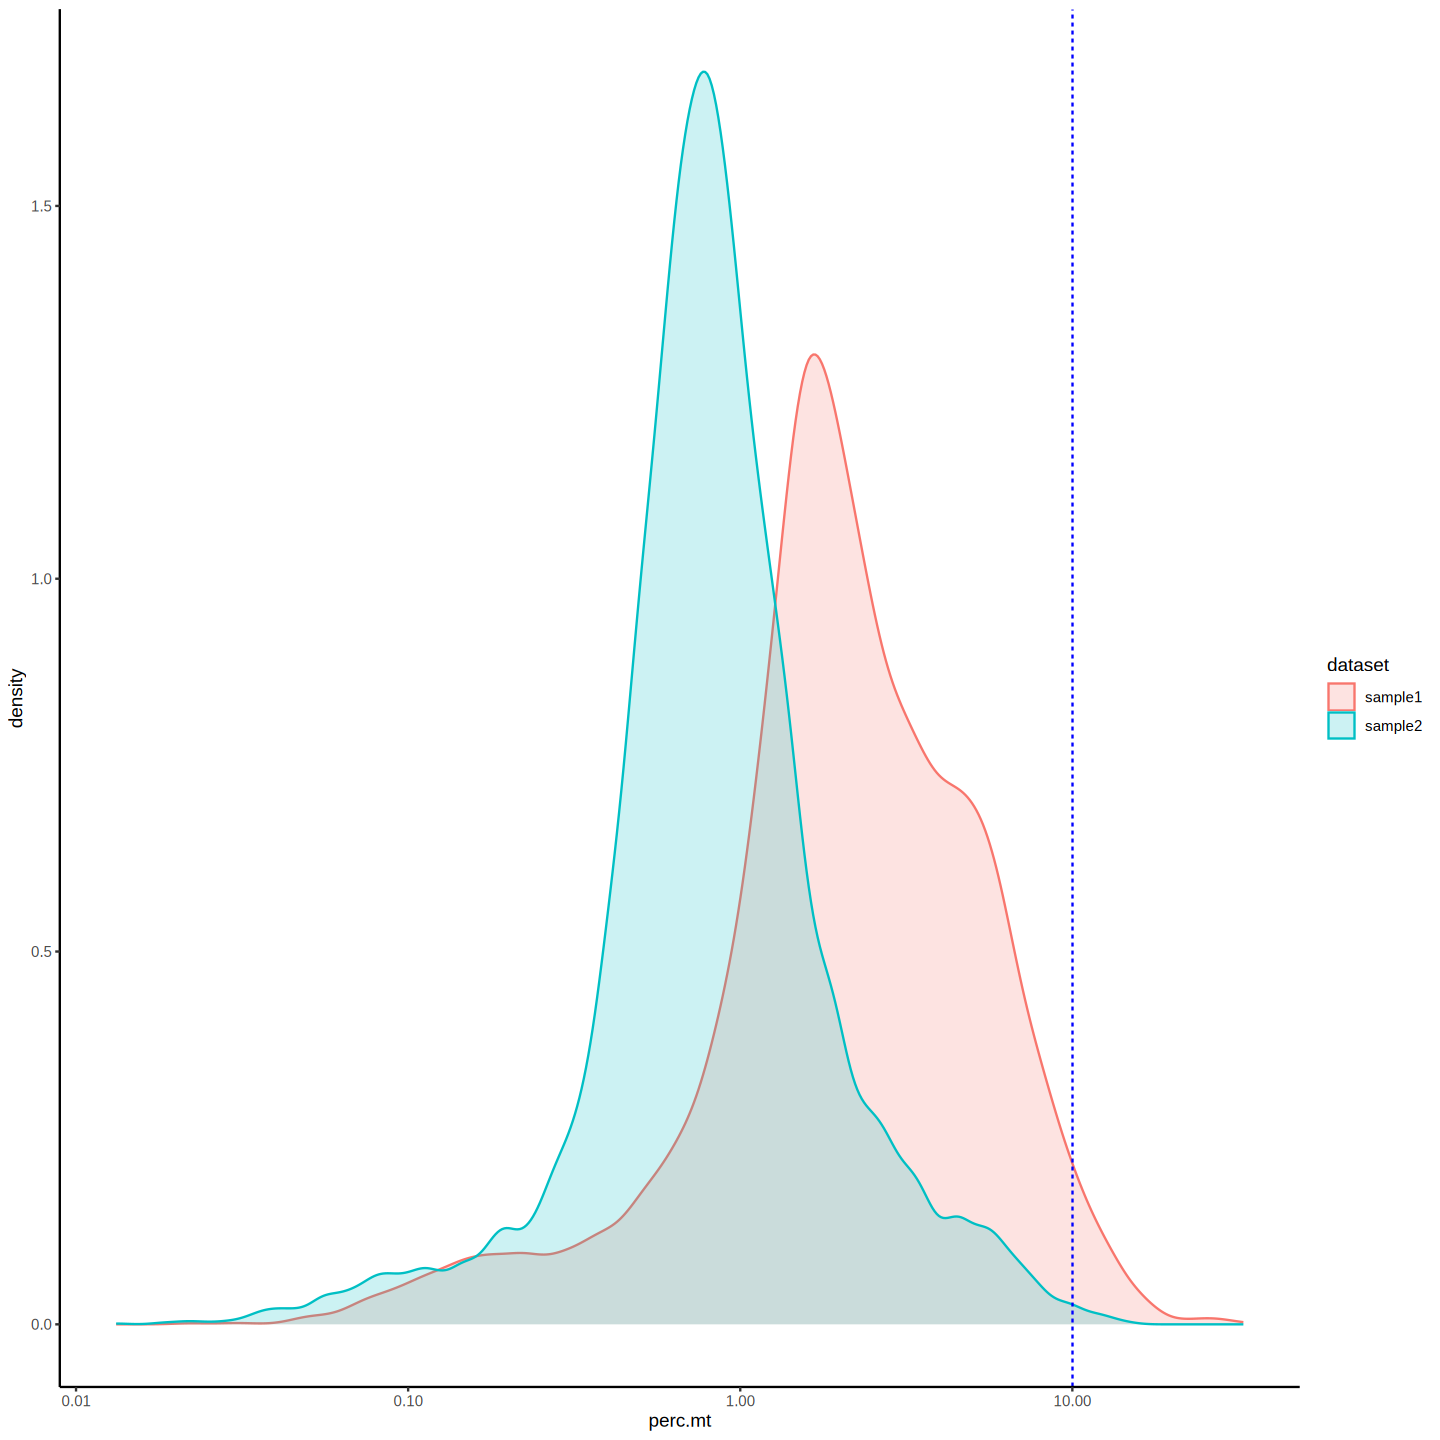

In [142]:
# Plot Percent of mitochondrial genes by Sample

rna_data@meta.data |>
  	ggplot(aes(color=dataset, x=perc.mt, fill=dataset)) + 
  	geom_density(alpha = 0.2) + 
  	scale_x_log10() + 
  	theme_classic() +
  	geom_vline(xintercept = 10, col = "blue", linetype = "dashed")



#### d. Apply quality control filtering to remove low-quality cells for each sample

In [29]:
rna_data_afterbasicQC <- subset(
    x = rna_data,
    subset =
        nCount_RNA > 500 & 
        # nCount_RNA < 20000 &
        nFeature_RNA > 200 & 
        nFeature_RNA < 20000 & 
        perc.mt < 10
)


In [31]:
rna_data_afterbasicQC

An object of class Seurat 
263561 features across 19690 samples within 1 assay 
Active assay: RNA (263561 features, 0 variable features)
 1 layer present: counts

In [32]:
saveRDS(rna_data_afterbasicQC, "../data/PBMC_rna.after_basic_qc.rds")

### Step 3. Doublet Detection

In [34]:

if (!requireNamespace("SingleCellExperiment", quietly = TRUE)) {
    BiocManager::install("SingleCellExperiment")
}

library(SingleCellExperiment)


In [37]:
sce <- scDblFinder(
    SingleCellExperiment(list(counts=rna_data_afterbasicQC@assays$RNA$counts)),
    clusters=TRUE, aggregateFeatures=TRUE, nfeatures=25, processing="normFeatures"
)

res_scDbl <- colData(sce)
res_scDbl$scDblFinder.p <- 1 - res_scDbl[,"scDblFinder.score"]
row.names(res_scDbl) <- colnames(rna_data_afterbasicQC@assays$RNA$counts)

Warning message in .checkSCE(sce):
“Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out”
Aggregating features...

Clustering cells...

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
12 clusters

Creating ~15752 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 1745 cells excluded from training.

iter=1, 1928 cells excluded from training.

iter=2, 1974 cells excluded from training.

Threshold found:0.42

2158 (11%) doublets called



In [39]:
head(res_scDbl)

DataFrame with 6 rows and 9 columns
                           scDblFinder.cluster scDblFinder.class
                                     <numeric>          <factor>
sample1_AAACAGCCAGAATGAC-1                   6           singlet
sample1_AAACAGCCAGCTACGT-1                   6           singlet
sample1_AAACAGCCAGGCCTTG-1                   6           singlet
sample1_AAACAGCCATAATGTC-1                   2           singlet
sample1_AAACATGCAGCAATAA-1                   4           singlet
sample1_AAACATGCAGCCAGAA-1                   2           singlet
                           scDblFinder.score scDblFinder.weighted
                                   <numeric>            <numeric>
sample1_AAACAGCCAGAATGAC-1       0.144875199            0.1321640
sample1_AAACAGCCAGCTACGT-1       0.005153422            0.0248670
sample1_AAACAGCCAGGCCTTG-1       0.179520413            0.3187760
sample1_AAACAGCCATAATGTC-1       0.217355072            0.2018071
sample1_AAACATGCAGCAATAA-1       0.070428915    

In [47]:
res_scDbl <- as.data.frame(res_scDbl)
res_scDbl$barcode <- rownames(res_scDbl)

res_scDbl |> head()


scDblFinder.cluster scDblFinder.class
sample1_AAACAGCCAGAATGAC-1 6                   singlet          
sample1_AAACAGCCAGCTACGT-1 6                   singlet          
sample1_AAACAGCCAGGCCTTG-1 6                   singlet          
sample1_AAACAGCCATAATGTC-1 2                   singlet          
sample1_AAACATGCAGCAATAA-1 4                   singlet          
sample1_AAACATGCAGCCAGAA-1 2                   singlet          
                           scDblFinder.score scDblFinder.weighted
sample1_AAACAGCCAGAATGAC-1 0.1448751986      0.13216398          
sample1_AAACAGCCAGCTACGT-1 0.0051534222      0.02486696          
sample1_AAACAGCCAGGCCTTG-1 0.1795204133      0.31877597          
sample1_AAACAGCCATAATGTC-1 0.2173550725      0.20180707          
sample1_AAACATGCAGCAATAA-1 0.0704289153      0.31801150          
sample1_AAACATGCAGCCAGAA-1 0.0006663838      0.03925010          
                           scDblFinder.difficulty scDblFinder.cxds_score
sample1_AAACAGCCAGAATGAC-1 0.1002894              0.73316999            
sample1_AAACAGCCAGCTACGT-1 0.1154779              0.19017897            
sample1_AAACAGCCAGGCCTTG-1 0.1002894              0.66773840            
sample1_AAACAGCCATAATGTC-1 0.2162678              0.85057518            
sample1_AAACATGCAGCAATAA-1 0.1244095              0.11467433            
sample1_AAACATGCAGCCAGAA-1 0.1262913              0.01628659            
                           scDblFinder.mostLikelyOrigin
sample1_AAACAGCCAGAATGAC-1 2+6                         
sample1_AAACAGCCAGCTACGT-1 3+8                         
sample1_AAACAGCCAGGCCTTG-1 2+6                         
sample1_AAACAGCCATAATGTC-1 5+8                         
sample1_AAACATGCAGCAATAA-1 2+3                         
sample1_AAACATGCAGCCAGAA-1 3+6                         
                           scDblFinder.originAmbiguous scDblFinder.p
sample1_AAACAGCCAGAATGAC-1 FALSE                       0.8551248    
sample1_AAACAGCCAGCTACGT-1  TRUE                       0.9948466    
sample1_AAACAGCCAGGCCTTG-1 FALSE                       0.8204796    
sample1_AAACAGCCATAATGTC-1 FALSE                       0.7826449    
sample1_AAACATGCAGCAATAA-1 FALSE                       0.9295711    
sample1_AAACATGCAGCCAGAA-1 FALSE                       0.9993336    
                           barcode                   
sample1_AAACAGCCAGAATGAC-1 sample1_AAACAGCCAGAATGAC-1
sample1_AAACAGCCAGCTACGT-1 sample1_AAACAGCCAGCTACGT-1
sample1_AAACAGCCAGGCCTTG-1 sample1_AAACAGCCAGGCCTTG-1
sample1_AAACAGCCATAATGTC-1 sample1_AAACAGCCATAATGTC-1
sample1_AAACATGCAGCAATAA-1 sample1_AAACATGCAGCAATAA-1
sample1_AAACATGCAGCCAGAA-1 sample1_AAACATGCAGCCAGAA-1

##### Integrate doublet-related metrics into the Seurat object

In [48]:


rna_data_afterbasicQC <- AddMetaData(object = rna_data_afterbasicQC, metadata = res_scDbl)

rna_data_afterbasicQC@meta.data |> head()


orig.ident    nCount_RNA nFeature_RNA dataset
sample1_AAACAGCCAGAATGAC-1 SeuratProject 36012      14745        sample1
sample1_AAACAGCCAGCTACGT-1 SeuratProject  9766       4756        sample1
sample1_AAACAGCCAGGCCTTG-1 SeuratProject 23885      10665        sample1
sample1_AAACAGCCATAATGTC-1 SeuratProject 52603      17516        sample1
sample1_AAACATGCAGCAATAA-1 SeuratProject 18307       8234        sample1
sample1_AAACATGCAGCCAGAA-1 SeuratProject 21711       9385        sample1
                           perc.mt   perc.ribo perc.hb     scDblFinder.cluster
sample1_AAACAGCCAGAATGAC-1 3.1433966 0.5970232 0.002776852 6                  
sample1_AAACAGCCAGCTACGT-1 3.0923613 0.4505427 0.010239607 6                  
sample1_AAACAGCCAGGCCTTG-1 3.4875445 0.6112623 0.004186728 6                  
sample1_AAACAGCCATAATGTC-1 0.8459594 0.6216375 0.000000000 2                  
sample1_AAACATGCAGCAATAA-1 0.2731196 0.5462391 0.005462391 4                  
sample1_AAACATGCAGCCAGAA-1 0.3730828 0.2717516 0.004605960 2                  
                           scDblFinder.class scDblFinder.score
sample1_AAACAGCCAGAATGAC-1 singlet           0.1448751986     
sample1_AAACAGCCAGCTACGT-1 singlet           0.0051534222     
sample1_AAACAGCCAGGCCTTG-1 singlet           0.1795204133     
sample1_AAACAGCCATAATGTC-1 singlet           0.2173550725     
sample1_AAACATGCAGCAATAA-1 singlet           0.0704289153     
sample1_AAACATGCAGCCAGAA-1 singlet           0.0006663838     
                           scDblFinder.weighted scDblFinder.difficulty
sample1_AAACAGCCAGAATGAC-1 0.13216398           0.1002894             
sample1_AAACAGCCAGCTACGT-1 0.02486696           0.1154779             
sample1_AAACAGCCAGGCCTTG-1 0.31877597           0.1002894             
sample1_AAACAGCCATAATGTC-1 0.20180707           0.2162678             
sample1_AAACATGCAGCAATAA-1 0.31801150           0.1244095             
sample1_AAACATGCAGCCAGAA-1 0.03925010           0.1262913             
                           scDblFinder.cxds_score scDblFinder.mostLikelyOrigin
sample1_AAACAGCCAGAATGAC-1 0.73316999             2+6                         
sample1_AAACAGCCAGCTACGT-1 0.19017897             3+8                         
sample1_AAACAGCCAGGCCTTG-1 0.66773840             2+6                         
sample1_AAACAGCCATAATGTC-1 0.85057518             5+8                         
sample1_AAACATGCAGCAATAA-1 0.11467433             2+3                         
sample1_AAACATGCAGCCAGAA-1 0.01628659             3+6                         
                           scDblFinder.originAmbiguous scDblFinder.p
sample1_AAACAGCCAGAATGAC-1 FALSE                       0.8551248    
sample1_AAACAGCCAGCTACGT-1  TRUE                       0.9948466    
sample1_AAACAGCCAGGCCTTG-1 FALSE                       0.8204796    
sample1_AAACAGCCATAATGTC-1 FALSE                       0.7826449    
sample1_AAACATGCAGCAATAA-1 FALSE                       0.9295711    
sample1_AAACATGCAGCCAGAA-1 FALSE                       0.9993336    
                           barcode                   
sample1_AAACAGCCAGAATGAC-1 sample1_AAACAGCCAGAATGAC-1
sample1_AAACAGCCAGCTACGT-1 sample1_AAACAGCCAGCTACGT-1
sample1_AAACAGCCAGGCCTTG-1 sample1_AAACAGCCAGGCCTTG-1
sample1_AAACAGCCATAATGTC-1 sample1_AAACAGCCATAATGTC-1
sample1_AAACATGCAGCAATAA-1 sample1_AAACATGCAGCAATAA-1
sample1_AAACATGCAGCCAGAA-1 sample1_AAACATGCAGCCAGAA-1

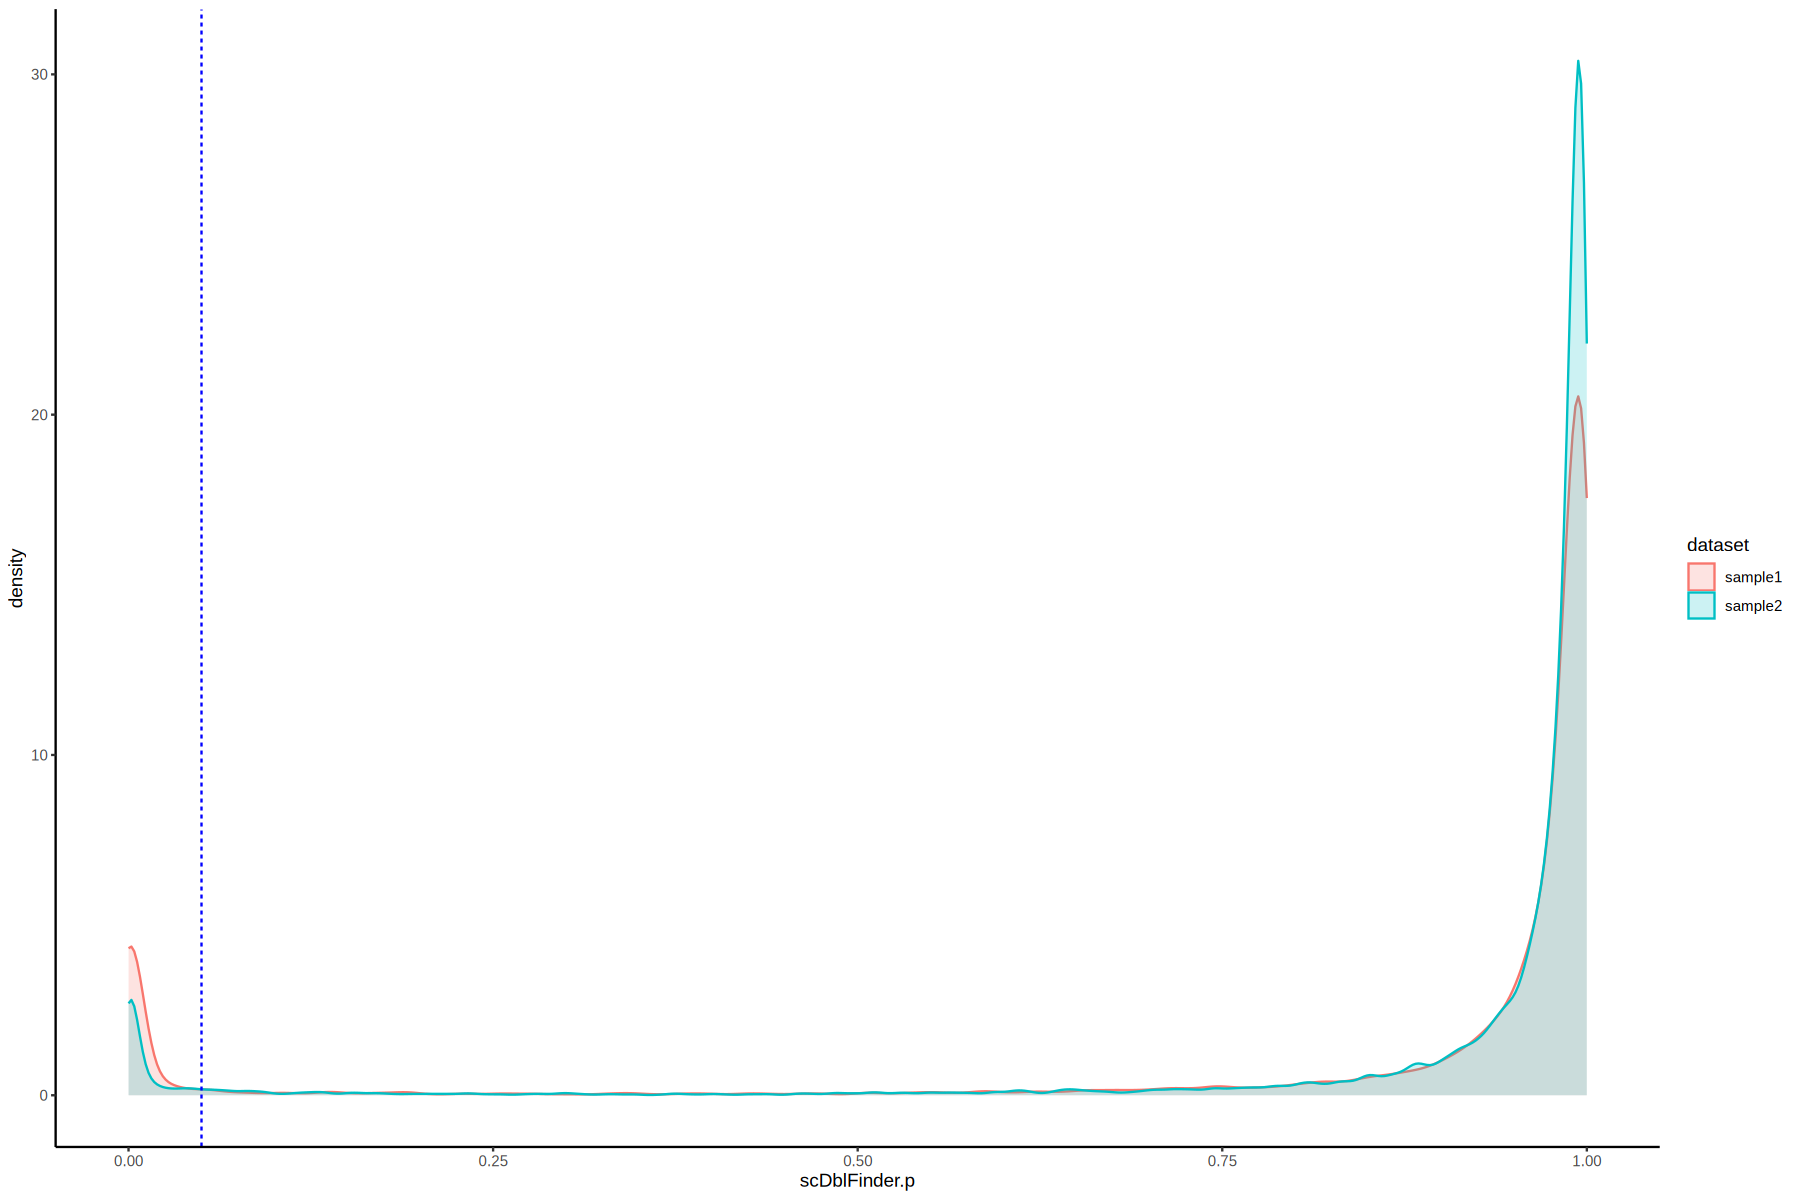

In [55]:
rna_data_afterbasicQC@meta.data |>
  	ggplot(aes(color=dataset, x=scDblFinder.p, fill=dataset)) + 
  	geom_density(alpha = 0.2) + 
  	theme_classic() +
  	geom_vline(xintercept = 0.05, col = "blue", linetype = "dashed")

##### Apply doublet filtering

In [56]:
rna_data_afterQC <- subset(
    x = rna_data_afterbasicQC,
    subset = scDblFinder.p > 0.05
)

In [57]:
rna_data_afterQC

An object of class Seurat 
263561 features across 18119 samples within 1 assay 
Active assay: RNA (263561 features, 0 variable features)
 1 layer present: counts

In [58]:
saveRDS(rna_data_afterQC, "../data/PBMC_rna.after_qc.rds")

### Step 4. Normalization

##### Split RNA object by batch

In [14]:
rna_obj_list <- SplitObject(rna_data_afterQC, split.by = "dataset")
rna_obj_list

$sample1
An object of class Seurat 
263561 features across 8672 samples within 1 assay 
Active assay: RNA (263561 features, 0 variable features)
 1 layer present: counts

$sample2
An object of class Seurat 
263561 features across 9447 samples within 1 assay 
Active assay: RNA (263561 features, 0 variable features)
 1 layer present: counts


##### Perform SCTransform for each batch separately

In [15]:
# SCTransform
library(sctransform)
rna_obj_list <- lapply(X=rna_obj_list, FUN = function(x) {
    x <- SCTransform(x, method="glmGamPoi", vars.to.regress="perc.mt")
})


Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 23565 by 8672

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 168 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23565 genes

Computing corrected count matrix for 23565 genes

Calculating gene attributes

Wall clock passed: Time difference of 50.06373 secs

Determine variable features

Regressing out perc.mt

Centering data matrix

Getting residuals for block 1(of 2) for counts dataset

Getting residuals for block 2(of 2) for counts dataset

Regressing out perc.mt

Centering data matrix

Finished calculating residuals for counts

Set default assay to SCT

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.f

In [16]:
rna_features <- SelectIntegrationFeatures(object.list=rna_obj_list, nfeatures=3000)

In [17]:
# merge transformed objs without SCT-based integration
rna_merged <- merge(
    x = rna_obj_list[[1]],
    y = rna_obj_list[2:length(rna_obj_list)],
    merge.data = TRUE
)
DefaultAssay(rna_merged) <- "SCT"


In [18]:
VariableFeatures(rna_merged) <- rna_features

### Step 5. Dimensionality Reduction

In [19]:
rna_merged <- RunPCA(rna_merged, assay = "SCT", npcs=50)

PC_ 1 
Positive:  LYZ, VCAN, NAMPT, SAT1, PLXDC2, NEAT1, ZEB2, SLC8A1, DPYD, LRMDA 
	   FCN1, LYN, ARHGAP26, S100A9, AOAH, PLCB1, CSF3R, GAB2, ACSL1, RBM47 
	   SRGN, PLAUR, CD36, IL1B, IRAK3, PSAP, TBXAS1, MCTP1, ANXA1, CD74 
Negative:  BCL2, BCL11B, BACH2, LEF1, INPP4B, SKAP1, CAMK4, RPS27, RPL13, RPL13A 
	   CD247, PRKCH, IL7R, RPS27A, RPS2, RPL41, IL32, ARHGAP15, LTB, ANK3 
	   THEMIS, RPL3, RPL11, RPS18, TSHZ2, TC2N, RORA, RPLP1, TRAC, TRBC1 
PC_ 2 
Positive:  BANK1, IGHM, AFF3, CD74, RALGPS2, MS4A1, IGKC, CD79A, EBF1, PAX5 
	   OSBPL10, FCRL1, LINC00926, HLA-DRA, BLK, IGHD, COL19A1, CCSER1, NIBAN3, ADAM28 
	   CD22, CD79B, PLEKHG1, AP002075.1, KHDRBS2, ARHGAP24, COBLL1, LARGE1, HLA-DQA1, TCF4 
Negative:  GNLY, BCL11B, CD247, PRKCH, CCL5, INPP4B, NKG7, LEF1, CAMK4, DPYD 
	   IL32, IL7R, THEMIS, FYB1, NEAT1, AOAH, RORA, TC2N, ANXA1, PDE3B 
	   AAK1, TRBC1, PITPNC1, VCAN, PRKCA, TXK, TRAC, PRF1, FYN, ITK 
PC_ 3 
Positive:  LEF1, MAML2, TSHZ2, FHIT, BACH2, CAMK4, INPP4B, FOXP1, BCL2,

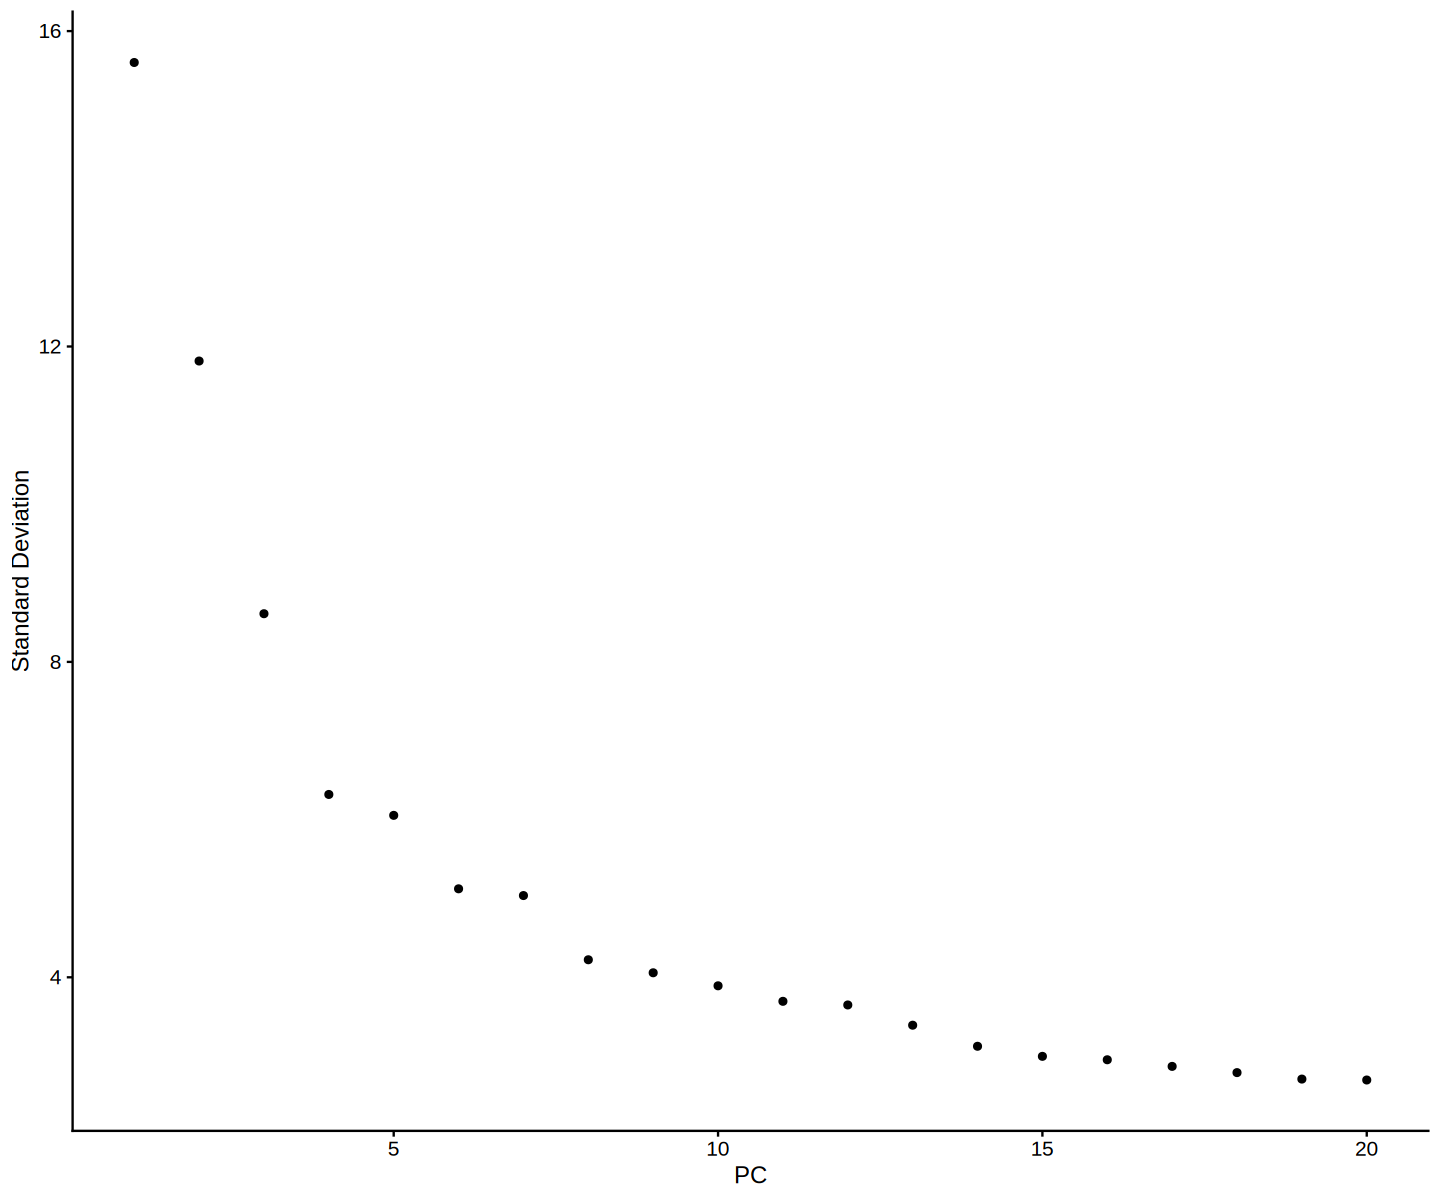

In [23]:
options(repr.plot.width = 12, repr.plot.height = 10)
ElbowPlot(rna_merged)

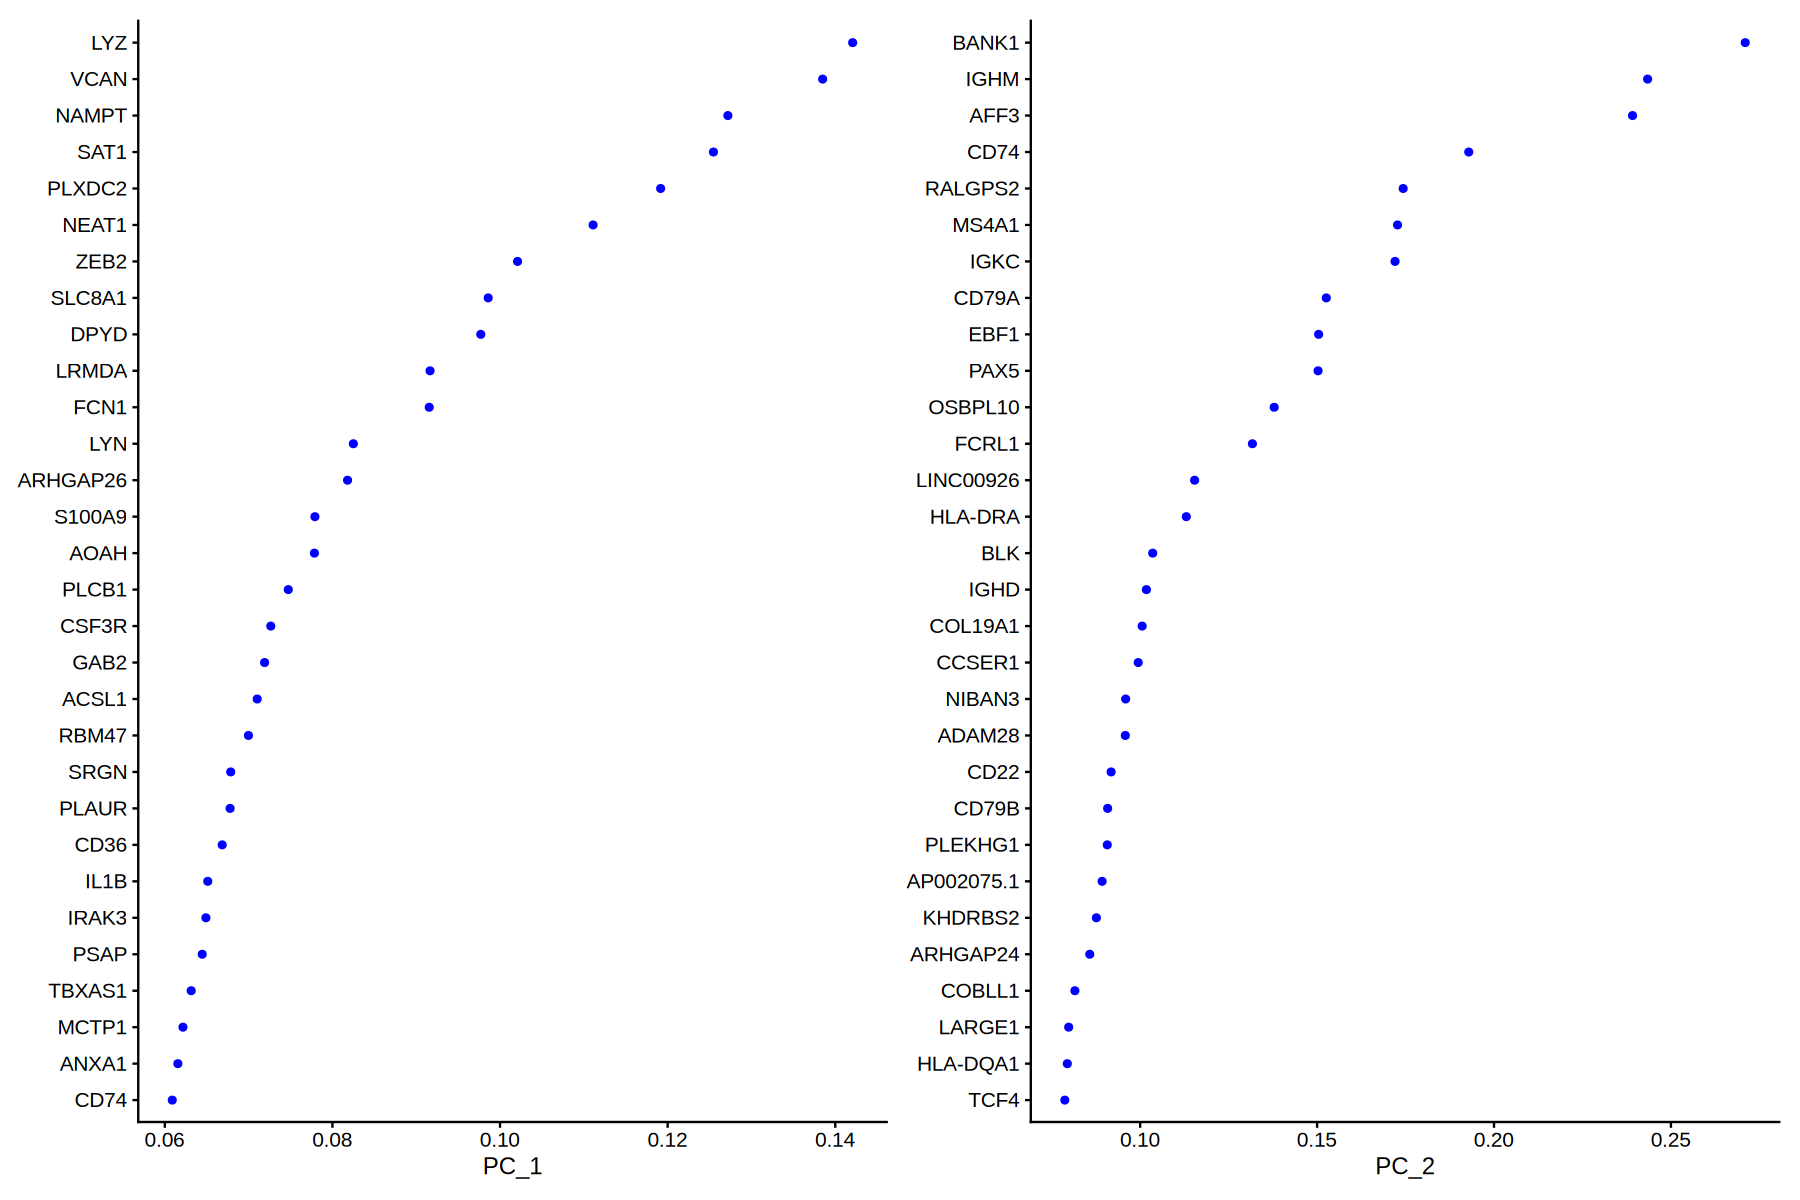

In [24]:
options(repr.plot.width = 15, repr.plot.height = 10)
VizDimLoadings(rna_merged, dims = 1:2, reduction = "pca")

### Step 6. Batch correction

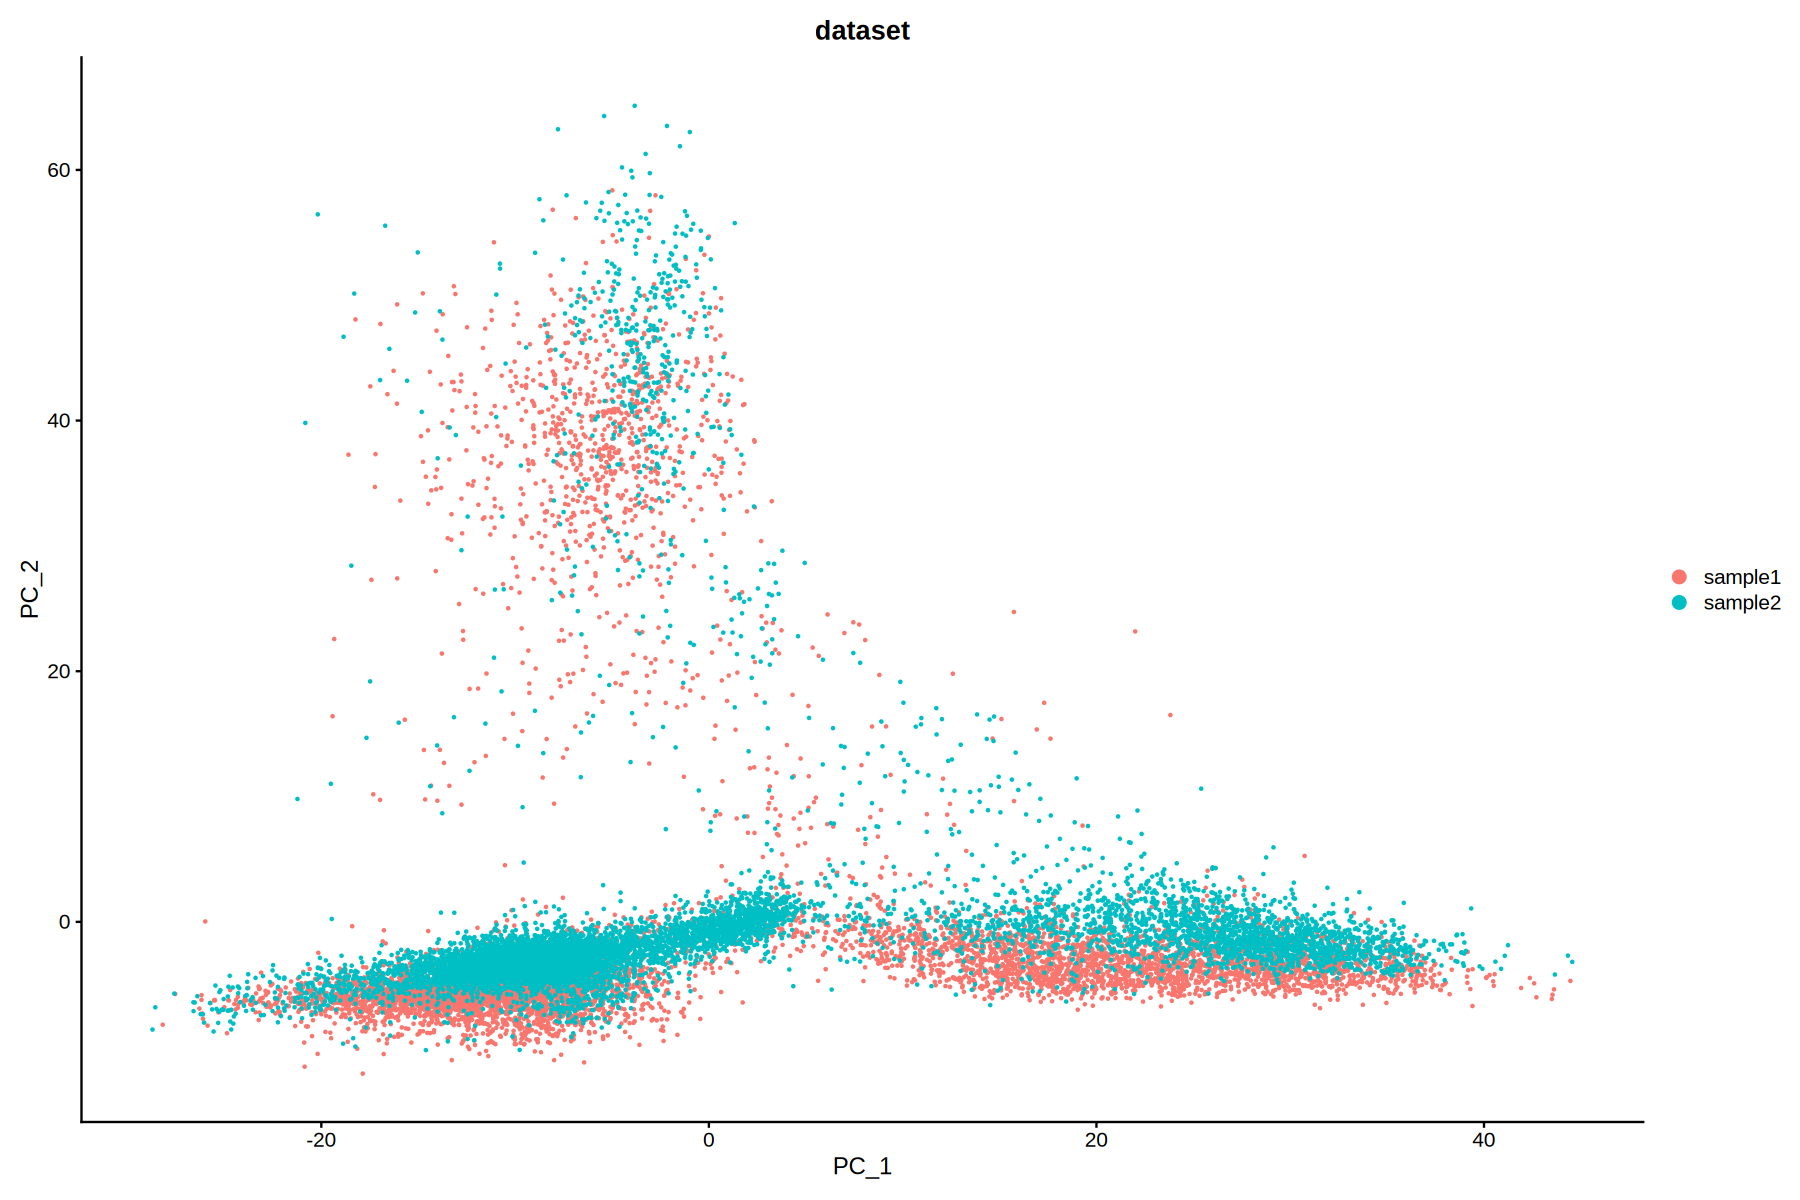

In [25]:
DimPlot(rna_merged, reduction = "pca", group.by = "dataset")

In [29]:
rna_merged <- RunUMAP(object = rna_merged, reduction = 'pca', dims = 1:50)

15:42:02 UMAP embedding parameters a = 0.9922 b = 1.112

15:42:02 Read 18119 rows and found 50 numeric columns

15:42:02 Using Annoy for neighbor search, n_neighbors = 30

15:42:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:42:04 Writing NN index file to temp file /tmp/RtmpcqJYDL/file127f15672d1ff1

15:42:04 Searching Annoy index using 1 thread, search_k = 3000

15:42:09 Annoy recall = 100%

15:42:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

15:42:12 Initializing from normalized Laplacian + noise (using RSpectra)

15:42:13 Commencing optimization for 200 epochs, with 794412 positive edges

15:42:13 Using rng type: pcg

15:42:22 Optimization finished



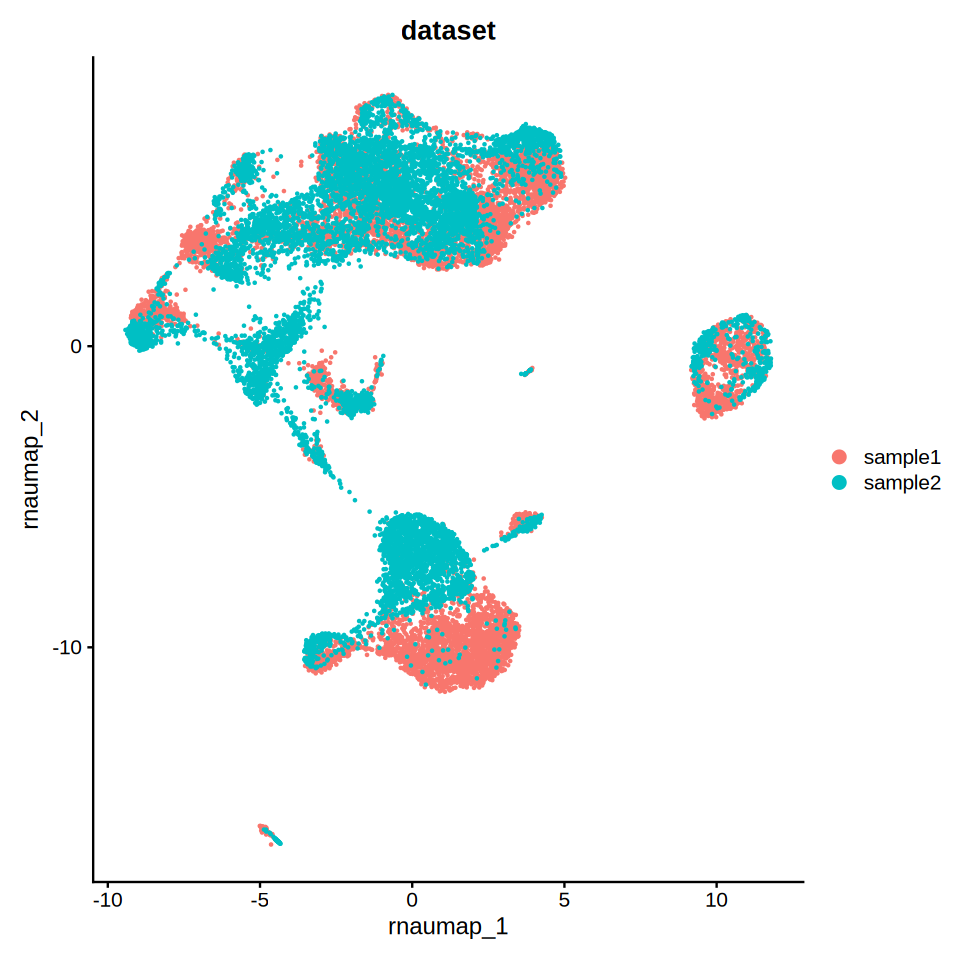

In [27]:
options(repr.plot.width = 8, repr.plot.height = 8)
p1 <- DimPlot(object = rna_merged,  group.by = 'dataset')
p1

In [101]:
rna_merged <- RunHarmony(
    object = rna_merged,
    group.by.vars = 'dataset',
    reduction = 'pca',
    assay.use = 'SCT',
    project.dim = FALSE,
    reduction.save = "harmony_rna"
)

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations



In [102]:
rna_merged <- RunUMAP(rna_merged, reduction="harmony_rna", dims=1:50)

14:07:05 UMAP embedding parameters a = 0.9922 b = 1.112

14:07:05 Read 18119 rows and found 50 numeric columns

14:07:05 Using Annoy for neighbor search, n_neighbors = 30

14:07:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:07:06 Writing NN index file to temp file /tmp/RtmpDiikwP/file3bb93a55c4afe2

14:07:06 Searching Annoy index using 1 thread, search_k = 3000

14:07:11 Annoy recall = 100%

14:07:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:07:14 Initializing from normalized Laplacian + noise (using RSpectra)

14:07:14 Commencing optimization for 200 epochs, with 801614 positive edges

14:07:14 Using rng type: pcg

14:07:24 Optimization finished



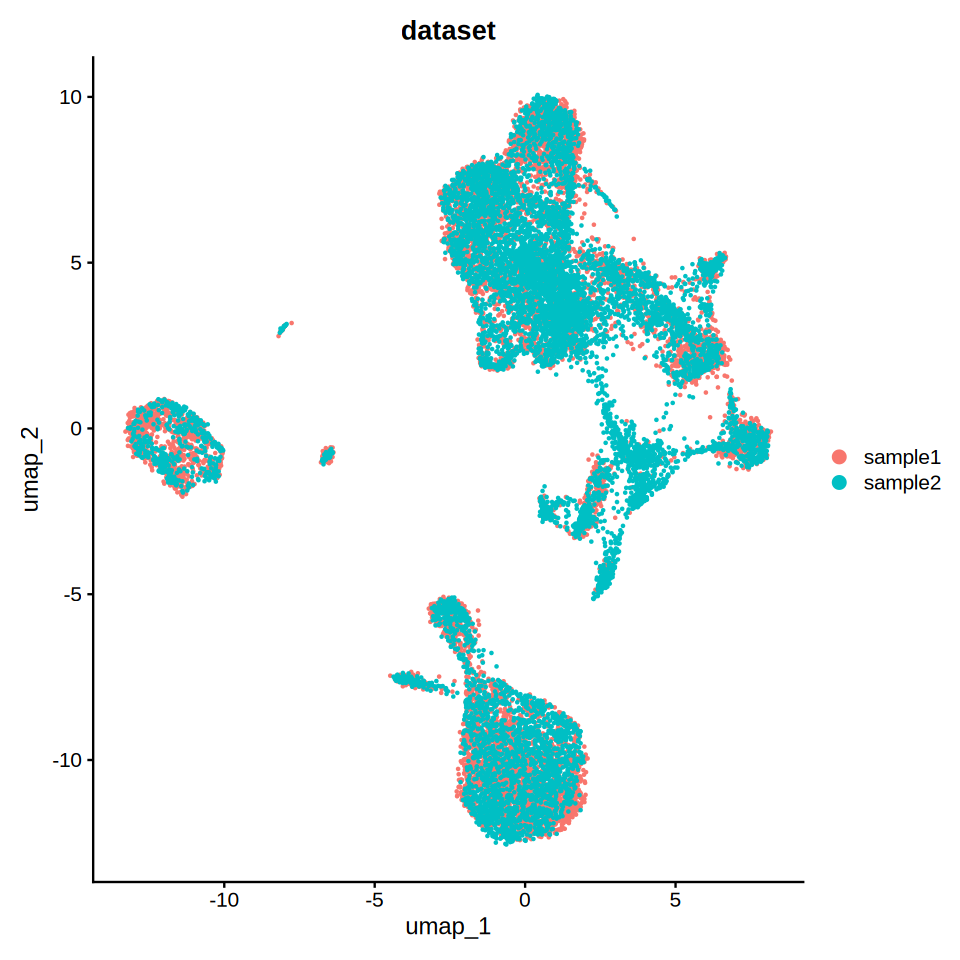

In [103]:
options(repr.plot.width=8, repr.plot.height=8)
p2 <- DimPlot(rna_merged, group.by='dataset')
p2

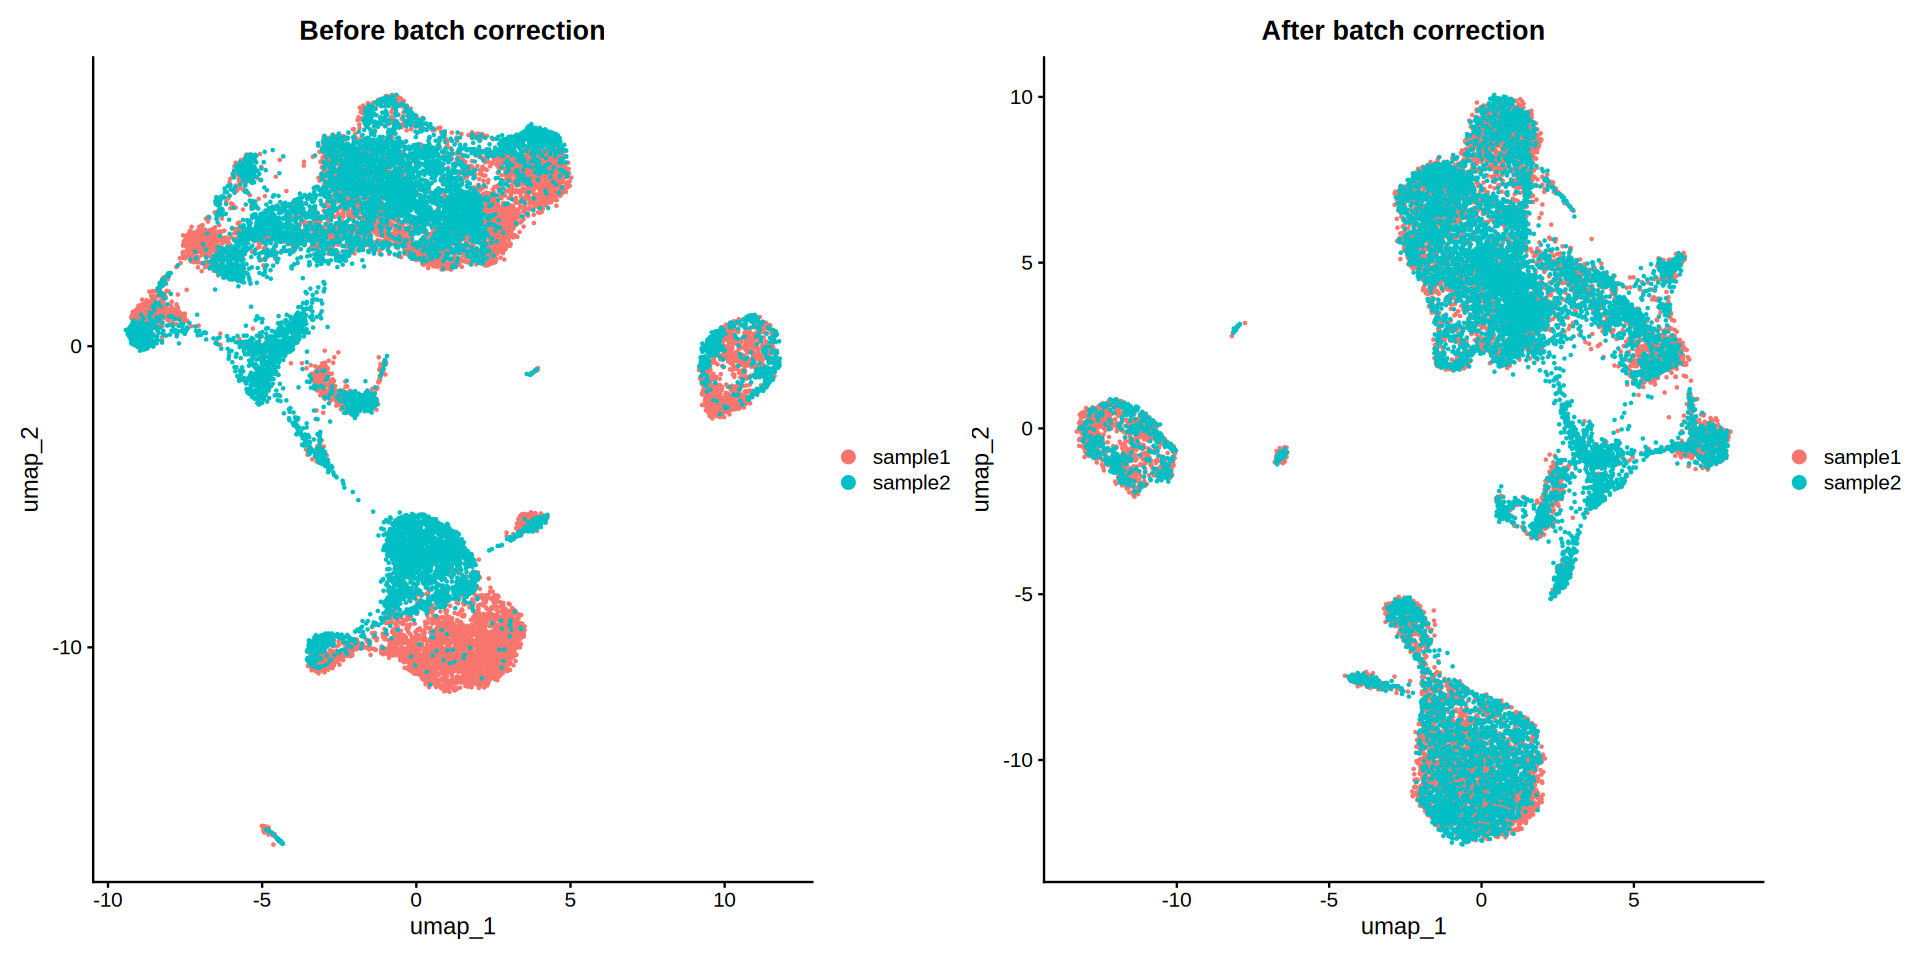

In [104]:
options(repr.plot.width = 16, repr.plot.height = 8)
(p1 + ggtitle("Before batch correction")) | (p2 + ggtitle("After batch correction"))

### Step 7. Clustering

In [105]:
rna_merged <- FindNeighbors(rna_merged, reduction="harmony_rna", dims=1:50)
rna_merged <- FindClusters(rna_merged, algorithm=3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18119
Number of edges: 700088

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.8780
Number of communities: 20
Elapsed time: 10 seconds


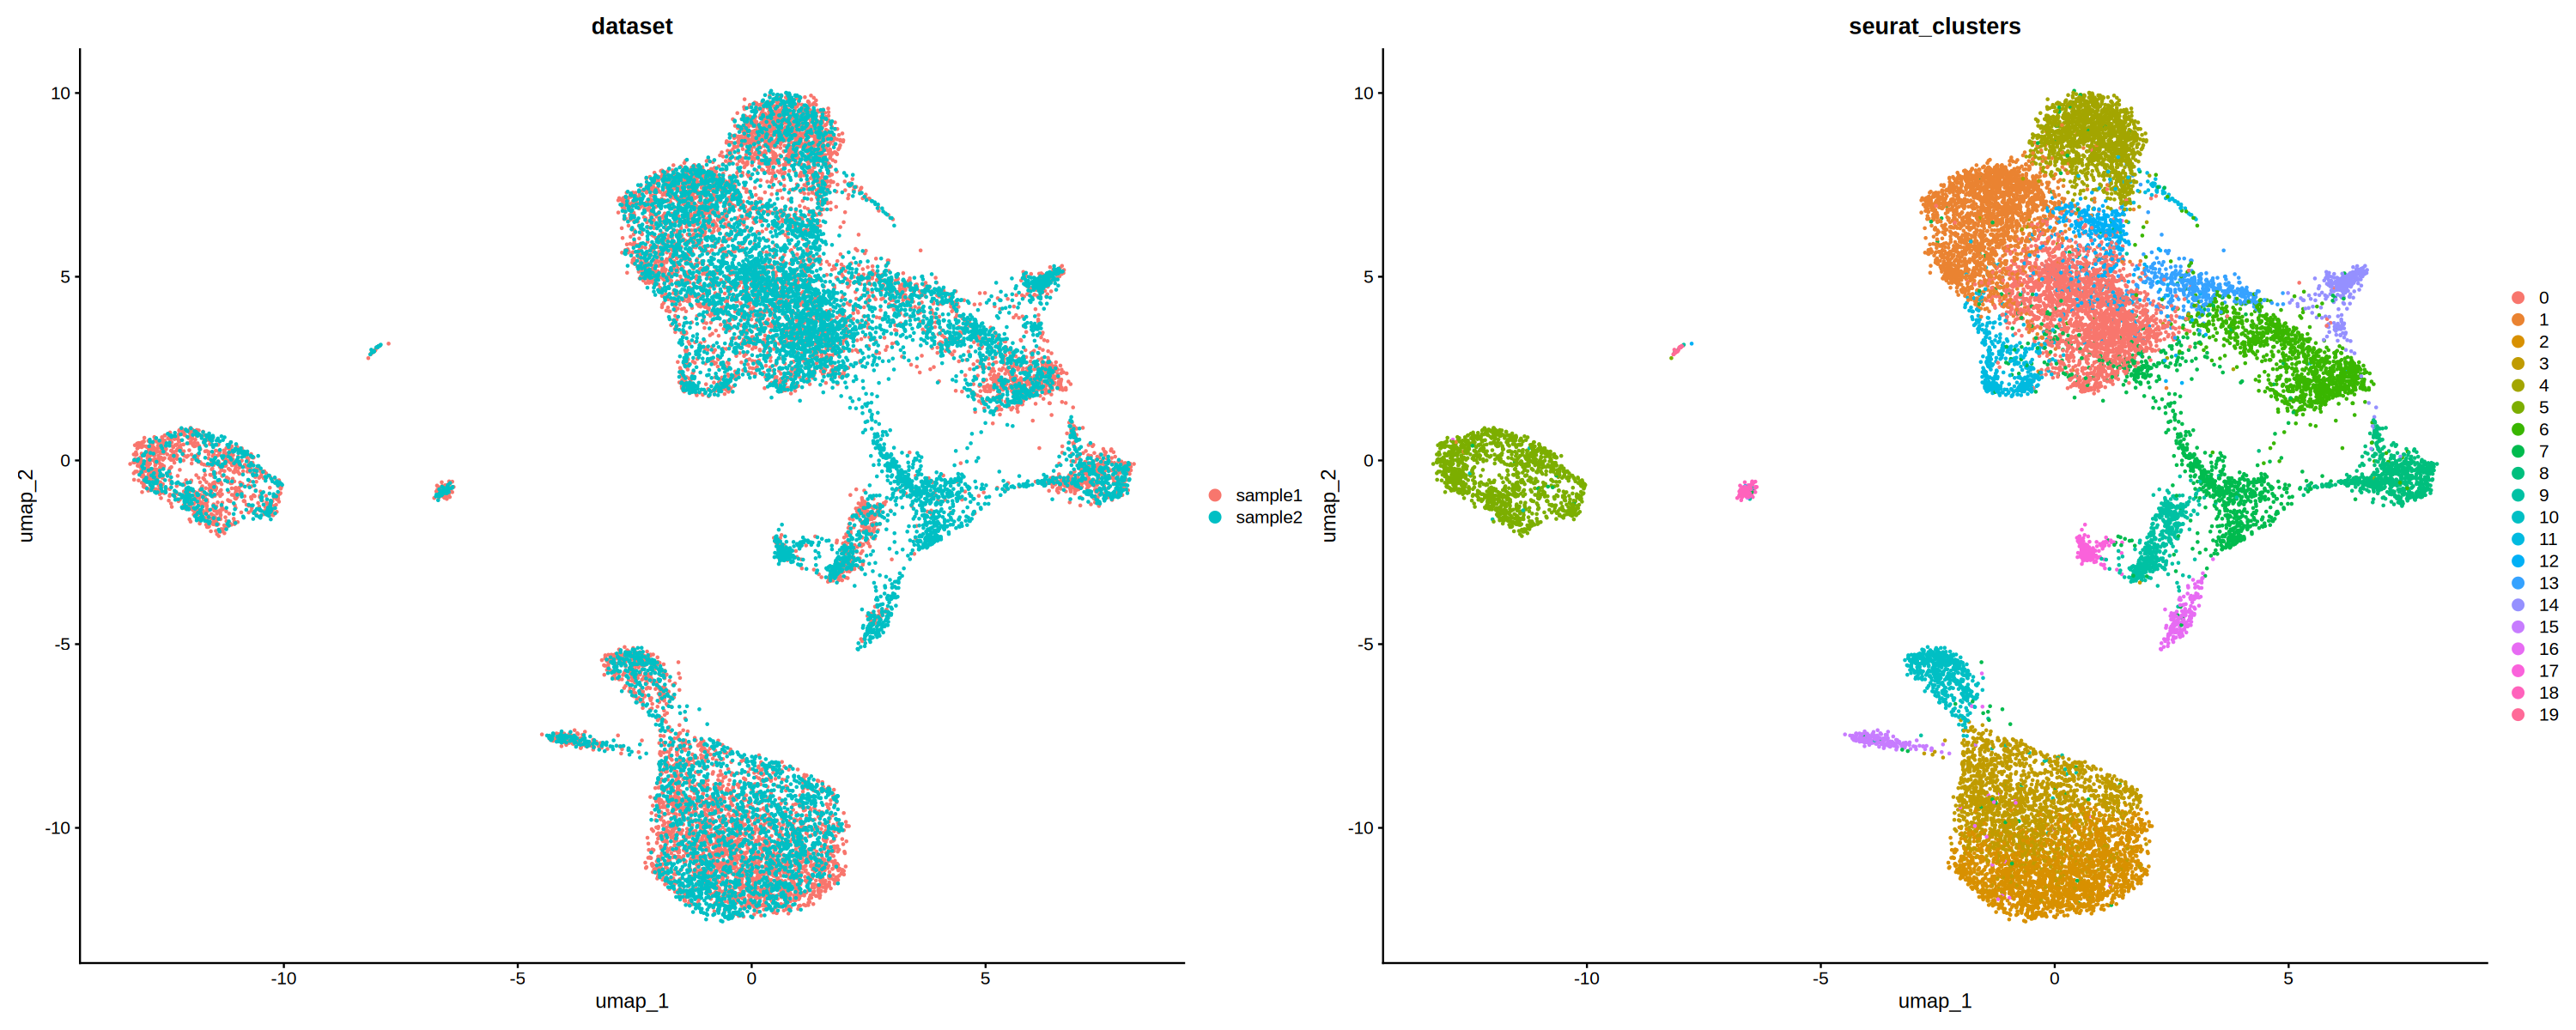

In [106]:
options(repr.plot.width=25, repr.plot.height=10)
DimPlot(rna_merged, group.by=c('dataset', 'seurat_clusters'))

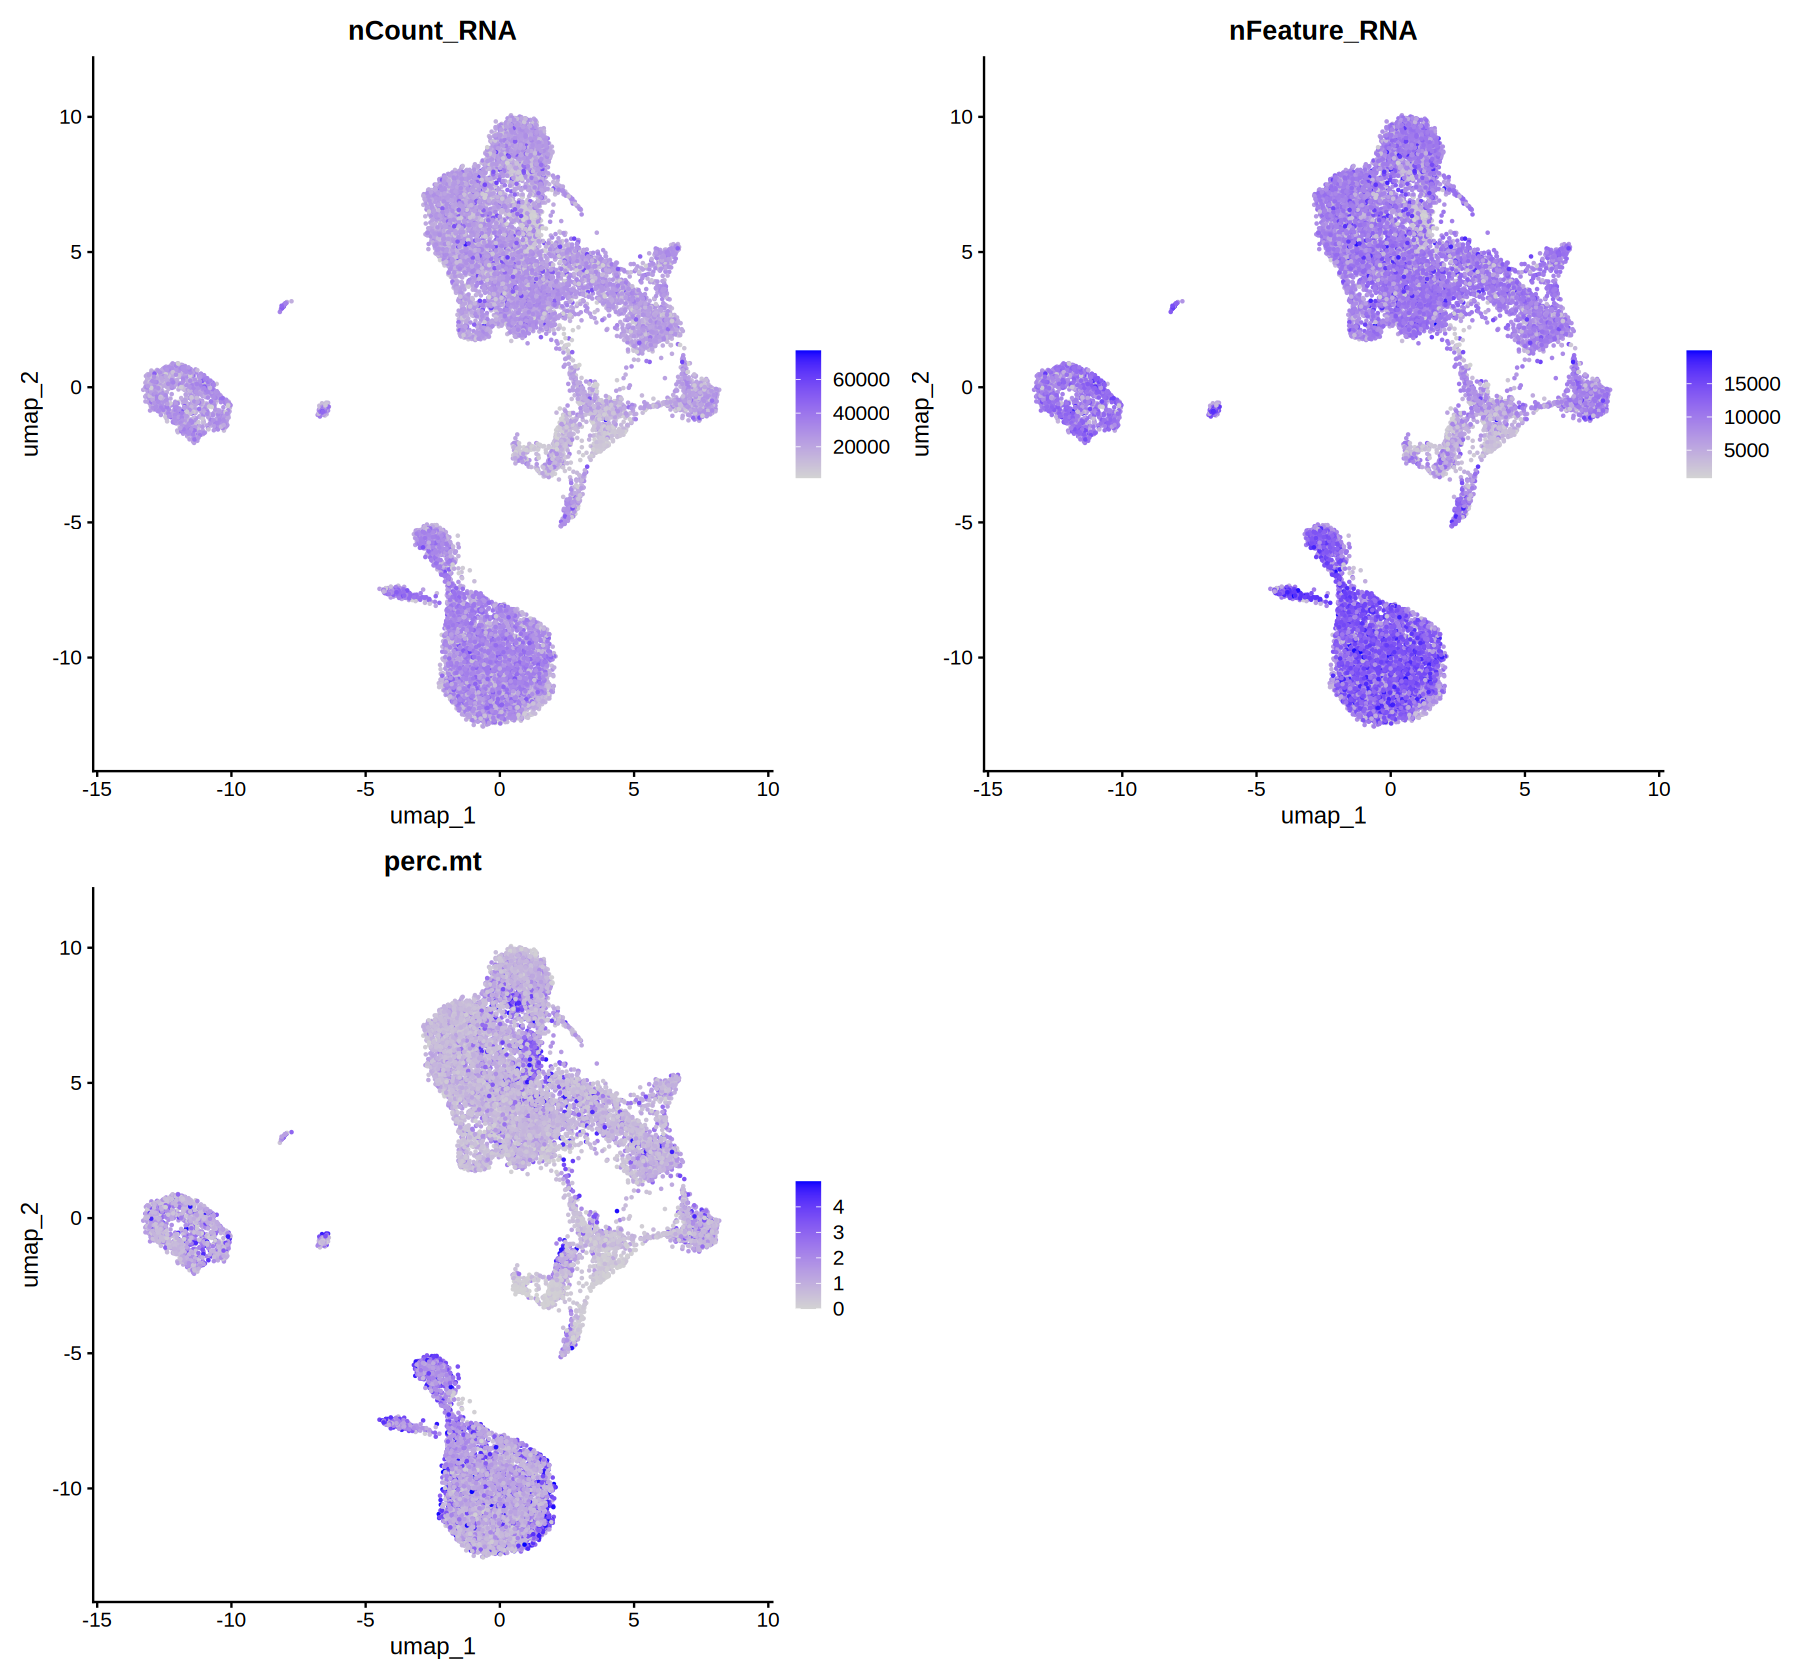

In [108]:
options(repr.plot.width=15, repr.plot.height=14)
FeaturePlot(rna_merged, features=c('nCount_RNA', 'nFeature_RNA', 'perc.mt'))

In [109]:
saveRDS(rna_merged,'../data/PBMC_rna.after_qc.batch_corrected.rds')

### Step 8. Cell type annotation

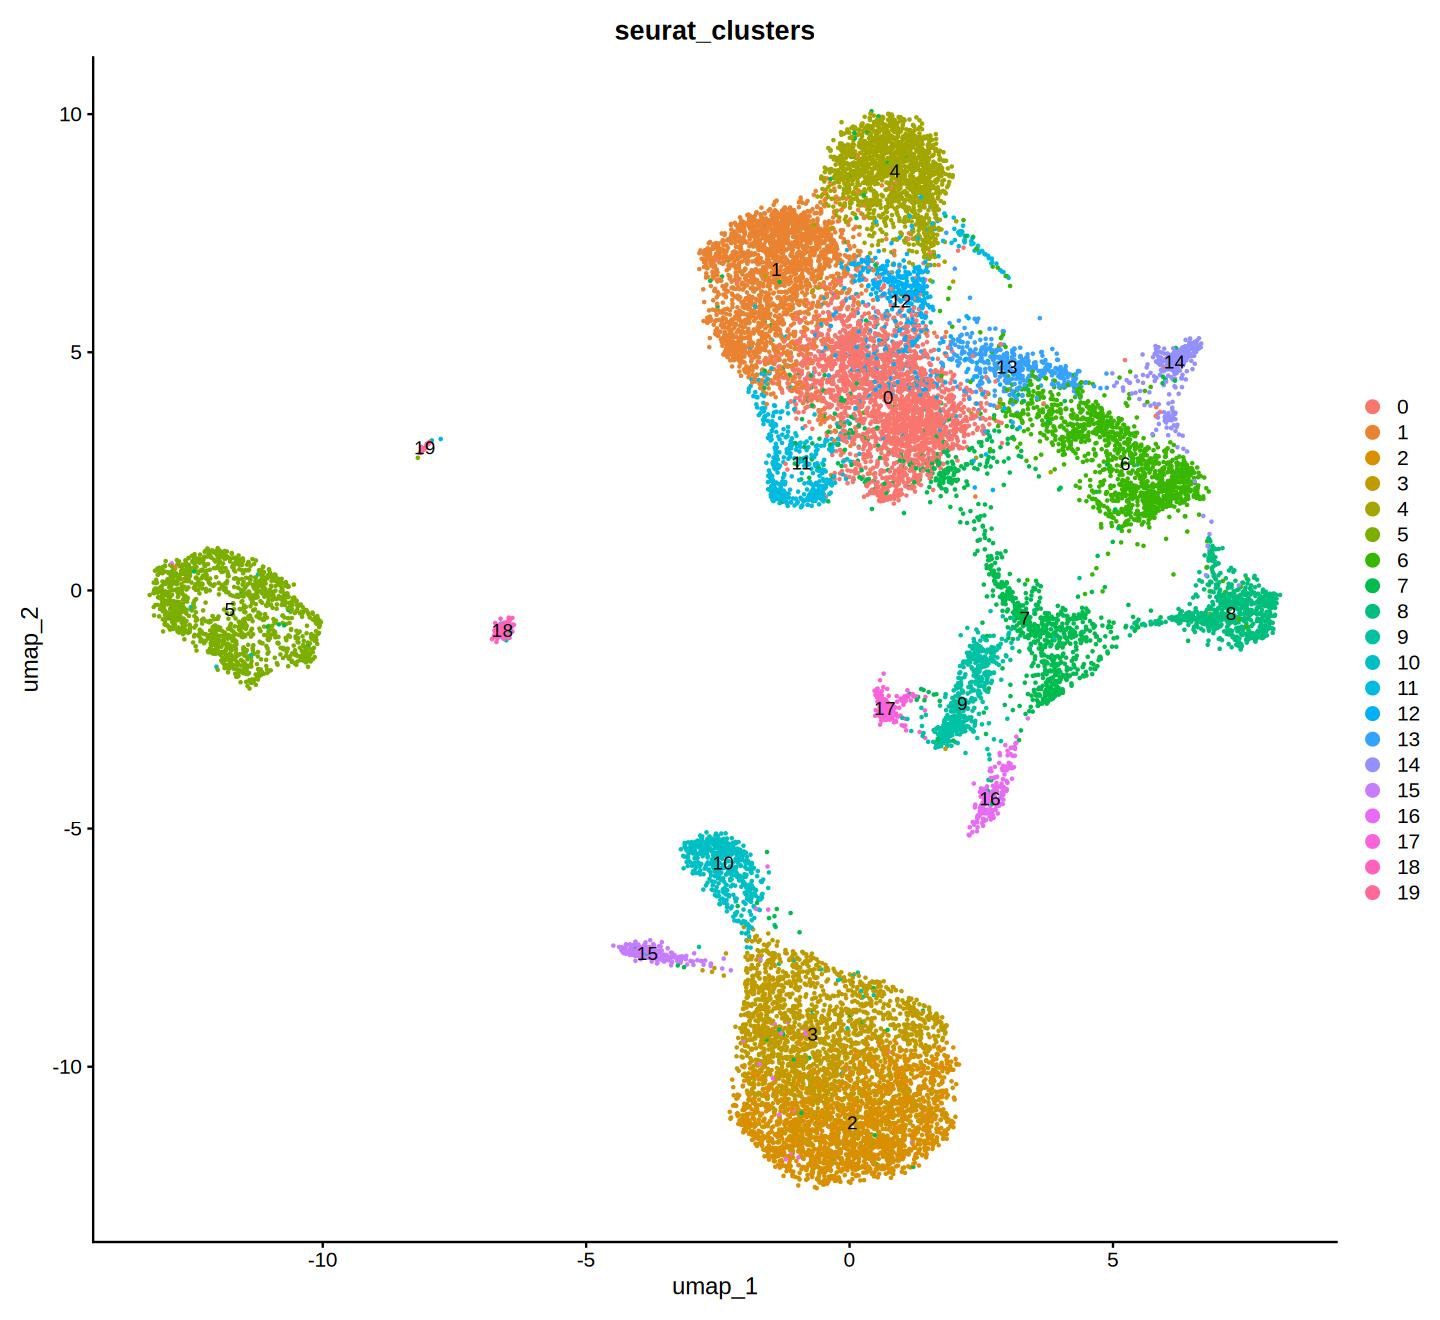

In [113]:
options(repr.plot.width=12, repr.plot.height=11)
DimPlot(rna_merged, group.by='seurat_clusters', label=T)

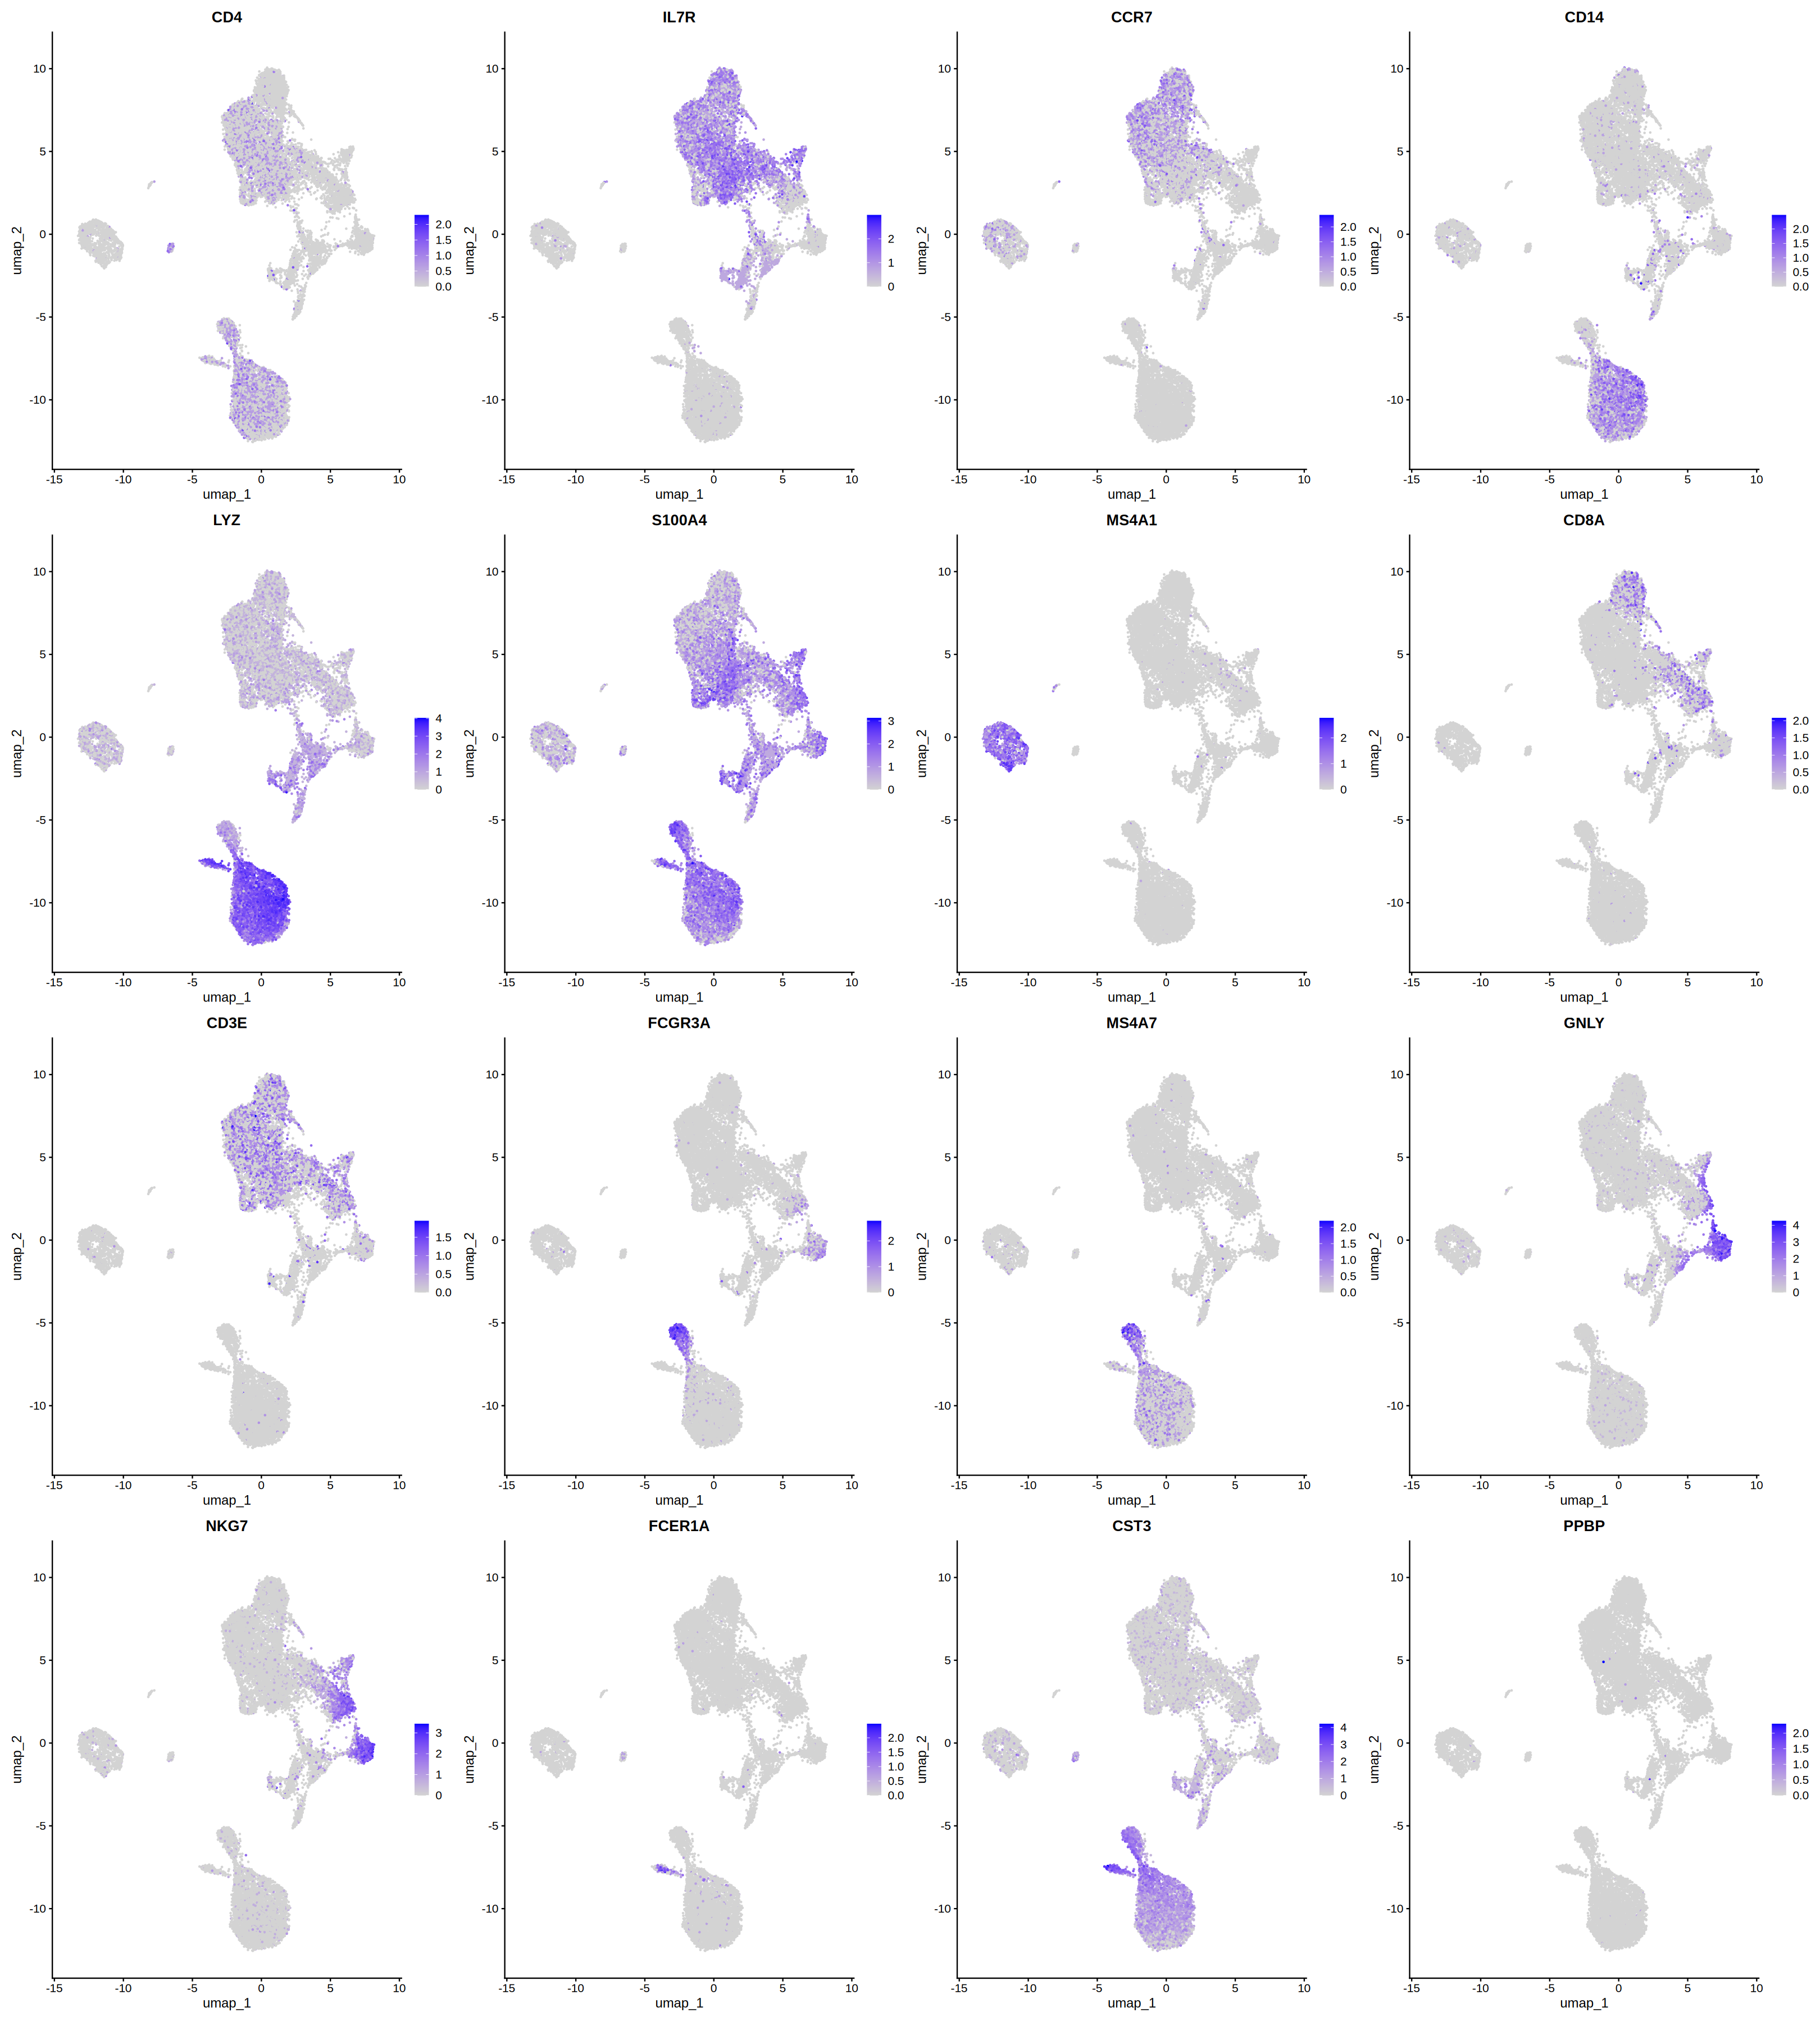

In [129]:

options(repr.plot.width = 27, repr.plot.height = 30)

FeaturePlot(rna_merged, features = c("CD4",
                                     "IL7R", "CCR7",   # Naive CD4+ T
                                     "CD14", "LYZ",    # CD14+ Mono
                                     "IL7R", "S100A4", # Memory CD4+ T
                                     "MS4A1",          # B 
                                     "CD8A", "CD3E",   # CD8+ T
                                     "FCGR3A", "MS4A7",# FCGR3A+ Mono
                                     "GNLY", "NKG7",   # NK
                                     "FCER1A", "CST3", # DC
                                     "PPBP"            # Platelet
                              ))




Cell types were annotsted manually based on marker genes:
- Naive CD4+ T cell: 0, 1, 11, 12, 13, 14
- CD14+ Monocyte: 2, 3 
- Memory CD4+ T cell: 7, 9, 16, 17
- B cell: 5
- CD8+ T cell: 4
- FCGR3A+ Monocyte: 10
- Natural killer cell: 6, 8
- Dendritic cells: 15
- No platelet
- Unknown: 18, 19

In [144]:
cluster_annot <- list(`Naive CD4 T`=c(0, 1, 11, 12, 13, 14),
                      `CD14+ Mono`=c(2, 3),
                      `Memory CD4 T`=c(7, 9, 16, 17),
                      `B`=c(5),
                      `CD8 T`=c(4),
                      `FCGR3A+ Mono`=c(10),
                      `NK`=c(6, 8),
                      `DC` = c(15)  #,`Unknown`=c(18, 19)
                     )

cluster_annot_tab <- stack(cluster_annot)
colnames(cluster_annot_tab) <- c('cluster', 'annot_cell_type')
cluster_annot_tab$cluster <- as.factor(cluster_annot_tab$cluster)
cluster_annot_tab$annot_cell_type <- as.factor(cluster_annot_tab$annot_cell_type)

cluster_annot_tab


cluster annot_cell_type
1  0       Naive CD4 T    
2  1       Naive CD4 T    
3  11      Naive CD4 T    
4  12      Naive CD4 T    
5  13      Naive CD4 T    
6  14      Naive CD4 T    
7  2       CD14+ Mono     
8  3       CD14+ Mono     
9  7       Memory CD4 T   
10 9       Memory CD4 T   
11 16      Memory CD4 T   
12 17      Memory CD4 T   
13 5       B              
14 4       CD8 T          
15 10      FCGR3A+ Mono   
16 6       NK             
17 8       NK             
18 15      DC

In [145]:
# only include known cell type
cells <- rownames(rna_merged@meta.data |> filter(!`SCT_snn_res.0.8` %in% c(18, 19)))
cell_count <- length(cells)
cat(paste0("Cell count: ", cell_count, "\n"))
rna_annot <- subset(rna_merged, cells = cells)


Cell count: 17961


In [146]:
# merge cell type with metadata
rna_annot@meta.data <- rna_annot@meta.data |> dplyr::left_join(cluster_annot_tab, by = c("SCT_snn_res.0.8" = "cluster"))
rownames(rna_annot@meta.data) <- rna_annot@meta.data$barcode
Idents(rna_annot) <- rna_annot@meta.data$annot_cell_type


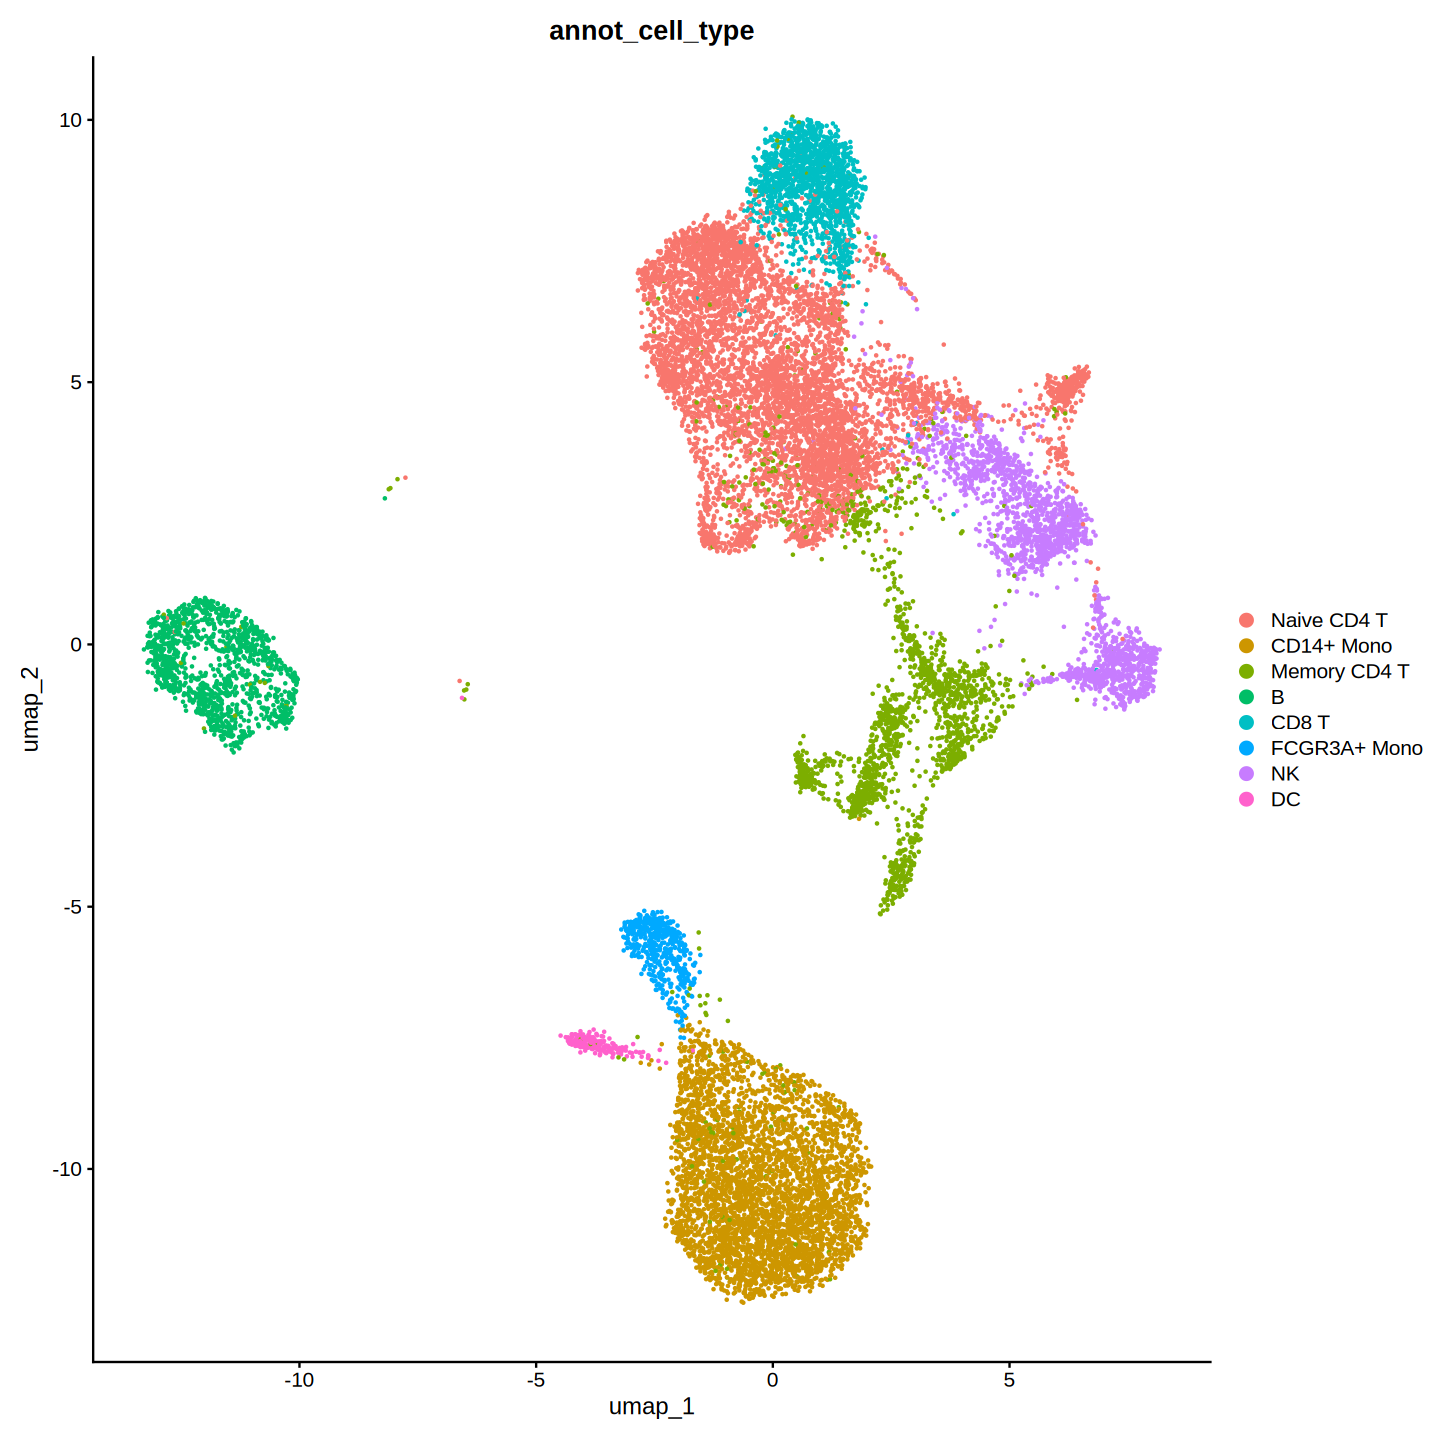

In [147]:
options(repr.plot.width = 12, repr.plot.height = 12)
DimPlot(object = rna_annot,
        group.by = "annot_cell_type",
        label = FALSE, label.size = 8,
        repel = TRUE)

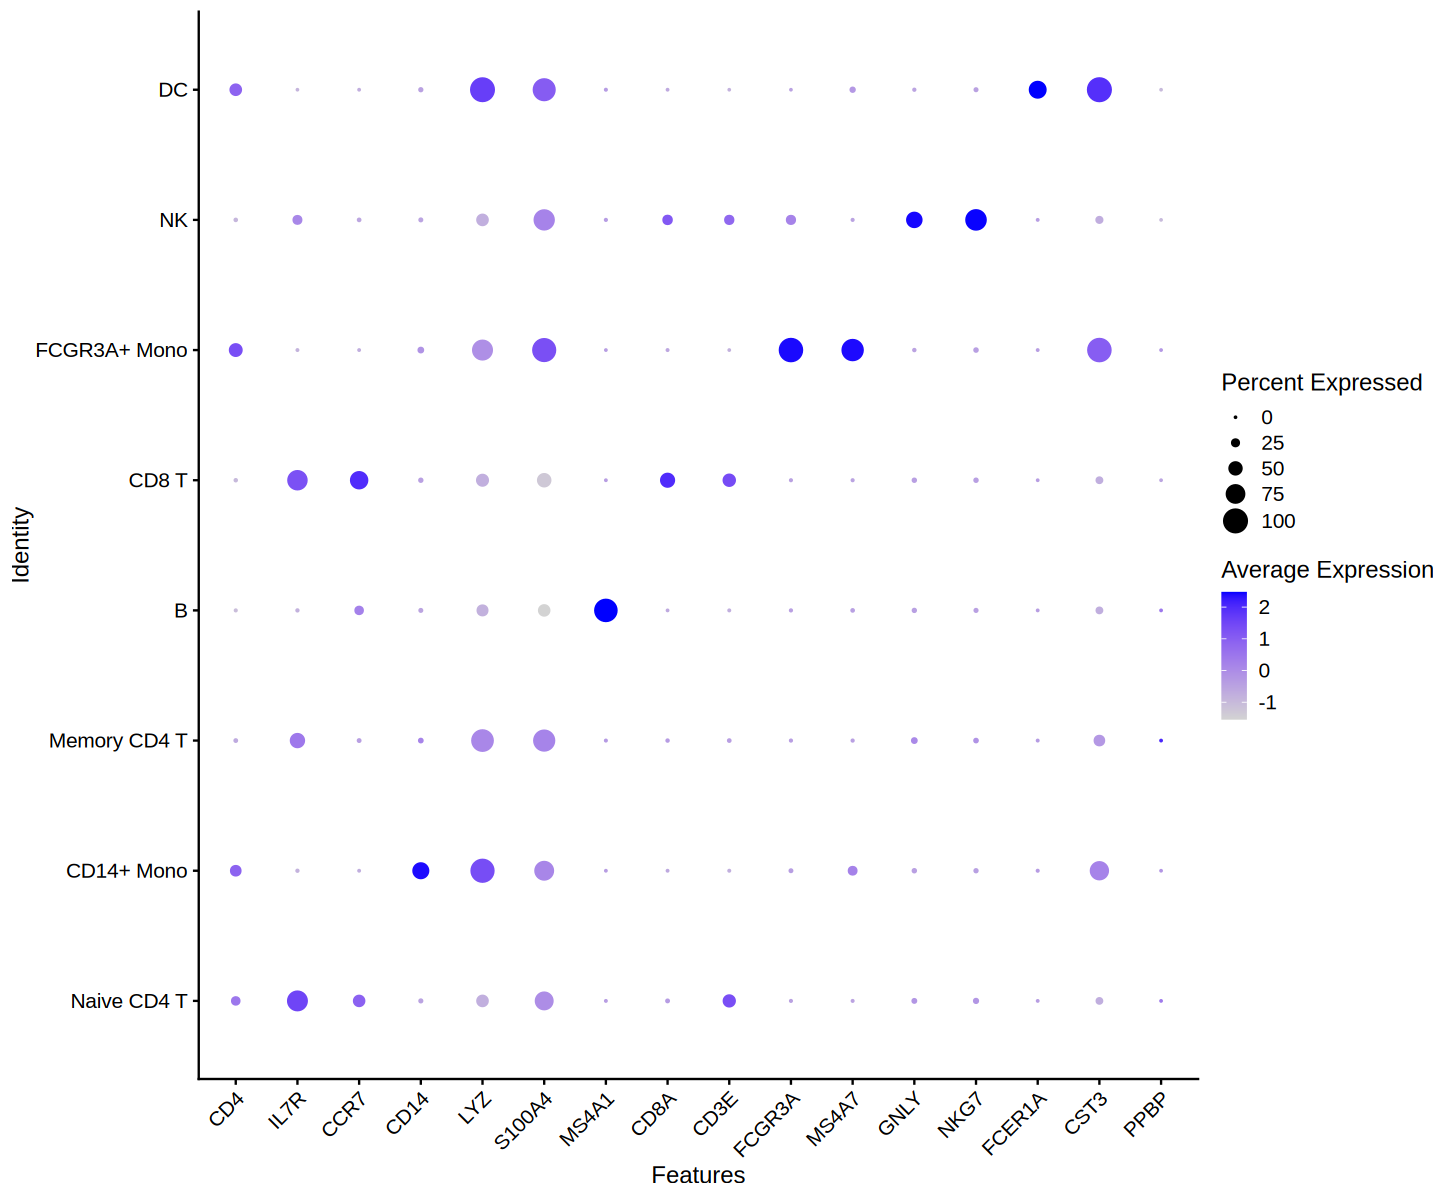

In [159]:
sel_markers <- c("CD4",
                 "IL7R", "CCR7",   # Naive CD4+ T
                 "CD14", "LYZ",    # CD14+ Mono
                 "S100A4",         # Memory CD4+ T
                 "MS4A1",          # B 
                 "CD8A", "CD3E",   # CD8+ T
                 "FCGR3A", "MS4A7",# FCGR3A+ Mono
                 "GNLY", "NKG7",   # NK
                 "FCER1A", "CST3", # DC
                 "PPBP"            # Platelet
                )


options(repr.plot.width=12, repr.plot.height=10)
DotPlot(rna_annot, features=sel_markers, cluster.idents=F, group.by = 'annot_cell_type') + RotatedAxis()

In [160]:
saveRDS(rna_annot, "../data/PBMC_rna.after_qc.batch_corrected.annotated.rds")

In [112]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.10 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /home/ch260976/.conda/envs/jlab/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] harmony_1.2.0               Rcpp_1.0.14                
 [3] sctransform_0.4.1           RColorBrewer_1.1-3         
 [5] ggplot2_3.5.1               stringr_1.5.1              
 [7] tidyr_1.